IMPORTS WILL GO FIRST

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

In [3]:
df = pd.read_csv('online_shoppers_intention.csv', na_values=['NA', 'null', '', 'NULL'])

PREPROCESSING



Step 1: Column transformer 

for numerical variables: we will use Standard Scaler 
for categorical variables: we will do one hot encoding or label encoding, depending on the nature of the feature

Step 2. Getting rid of outliers

Step 3. Normalization

Step 4. Dimention reduction 

for the dimension reduction we will use the Uniform Manifold Approximation and Projection (UMAP)
as it balances local and global structure preservation,


In [4]:
# Step 1: Column transformer
var_num = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
           'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
var_nom = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
var_bin = ['VisitorType', 'Weekend', 'Revenue']
var_ord = ['Month']

In [5]:
from sklearn.preprocessing import OneHotEncoder
# One hot encoding the nominal variables
def one_hot_encode(df, var_nom):
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(df[var_nom])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(var_nom))
    df_encoded = pd.concat([df, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(var_nom, axis=1)
    return df_encoded

var_nom = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']

df_encoded = one_hot_encode(df, var_nom)

# Label encoding the ordinal variables
label_encoder = LabelEncoder()
df_encoded['Month'] = label_encoder.fit_transform(df_encoded['Month'])

# Label encode binary variables and filter VisitorType
def preprocess_binary_columns(df):
    df['Weekend'] = df['Weekend'].astype(int)  
    df['Revenue'] = df['Revenue'].astype(int)  

    df['VisitorType'] = df['VisitorType'].map({'New_Visitor': 1, 'Returning_Visitor': 0})

    # Drop rows where VisitorType is "Other"
    df = df.dropna(subset=['VisitorType'])

    return df

# Apply binary column processing to df_encoded
df_encoded = preprocess_binary_columns(df_encoded)


In [6]:
df_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend,Revenue,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_1,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,0.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,0.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,0.0,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will make two copies of df enconded

df_noise = includes outliers 
df_out = removed outliers

In [7]:
#Step 2. Getting rid of outliers
def removal_box_plot(df, column, upper_threshold):
    lower_threshold = df[column].min()
    removed_outliers = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)]
    outlier_count = df.shape[0] - removed_outliers.shape[0]

    if outlier_count == 0:
        return df  

    return removed_outliers

df_na = df_encoded.copy().dropna()

thresholds = {
    'Administrative': 11,
    'Administrative_Duration': 1000,
    'Informational': 5,
    'Informational_Duration': 300,
    'ProductRelated': 200,
    'ProductRelated_Duration': 4000,
    'BounceRates': 0.5,
    'ExitRates': 0.12,
    'PageValues': 20,
    'SpecialDay': 0.3
}

df_out = df_na
df_wout = df_encoded.copy()  # Copy of df_encoded with all data, including outliers

for column, upper_threshold in thresholds.items():
    df_out = removal_box_plot(df_out, column, upper_threshold)

df_out.reset_index(drop=True, inplace=True)


In [8]:
length_df_out = len(df_out)
length_df_wout = len(df_wout)

print("Length of df_out (after outlier removal):", length_df_out)
print("Length of df_wout (with outliers):", length_df_wout)


Length of df_out (after outlier removal): 8175
Length of df_wout (with outliers): 12245


n = 10596 in df_out
n = 12330 in df_noise 

In [9]:
#Step 3. Normalization
df_names = df_out.columns
scaler = StandardScaler()
df_out = scaler.fit_transform(df_out)
df_wout = scaler.fit_transform(df_wout)
df_out = pd.DataFrame(df_out, columns=df_names)
df_wout = pd.DataFrame(df_wout, columns=df_names)

HERE WE WILL MAKE THE DIFFERENT DATA FRAMES, FOR THE DIMENSION REDUCTION TOOLS AS WELL AS FOR THE CORRESPONDENT CLUSTERING ALGORITHMS

In [10]:
# dataframe where the outliers are removed (ALL variables)
df_rem_out = df_out.copy()
df_rem_out_samp = df_rem_out.sample(n=6000, random_state=42).reset_index(drop=True)

# dataframe including outliers (ALL variables)
df_inc_out = df_wout.copy()
df_inc_out_samp = df_inc_out.sample(n=6000, random_state=42).reset_index(drop=True)


# data frame selecting only the NUMERIC variables where the outliers are REMOVED
df_num_rem_out = df_rem_out_samp[var_num].copy()

# dataframe selecting only the NUMERIC variables where the outliers are INCLUDED
df_num_inc_out = df_inc_out_samp[var_num].copy()


NOW WE WILL USE THE dataframe with the numerical variables to run the PCA 

In [11]:
#insert PCA 
# PCA using only numerical variables 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_num_scaled_rem_out = scaler.fit_transform(df_num_rem_out)
df_num_scaled_rem_out = pd.DataFrame(df_num_scaled_rem_out, columns=df_num_rem_out.columns)

df_num_scaled_inc_out = scaler.fit_transform(df_num_inc_out)
df_num_scaled_inc_out = pd.DataFrame(df_num_scaled_inc_out, columns=df_num_inc_out.columns)

from sklearn.decomposition import PCA

pca1 = PCA(n_components=5)
pca2 = PCA(n_components=5)
df_num_pca_rem_out = pca1.fit_transform(df_num_scaled_rem_out)
df_num_pca_inc_out = pca2.fit_transform(df_num_scaled_inc_out)

df_num_pca_rem_out = pd.DataFrame(data=df_num_pca_rem_out, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4', 'Principal Component 5'])
df_num_pca_inc_out = pd.DataFrame(data=df_num_pca_inc_out, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4', 'Principal Component 5'])

explained_variance_rem_out = pca1.explained_variance_ratio_
explained_variance_inc_out = pca2.explained_variance_ratio_
print("Explained variance for each component (without outliers):", explained_variance_rem_out)
print("Total explained variance:", explained_variance_rem_out.sum())
print("Explained variance for each component (with outliers):", explained_variance_inc_out)
print("Total explained variance:", explained_variance_inc_out.sum())

Explained variance for each component (without outliers): [0.30230449 0.15018933 0.12717967 0.1163066  0.09962071]
Total explained variance: 0.7956007965496908
Explained variance for each component (with outliers): [0.34543622 0.16942189 0.10559948 0.09682459 0.09219203]
Total explained variance: 0.8094741954381189


Number of clusters found by DBSCAN: 4


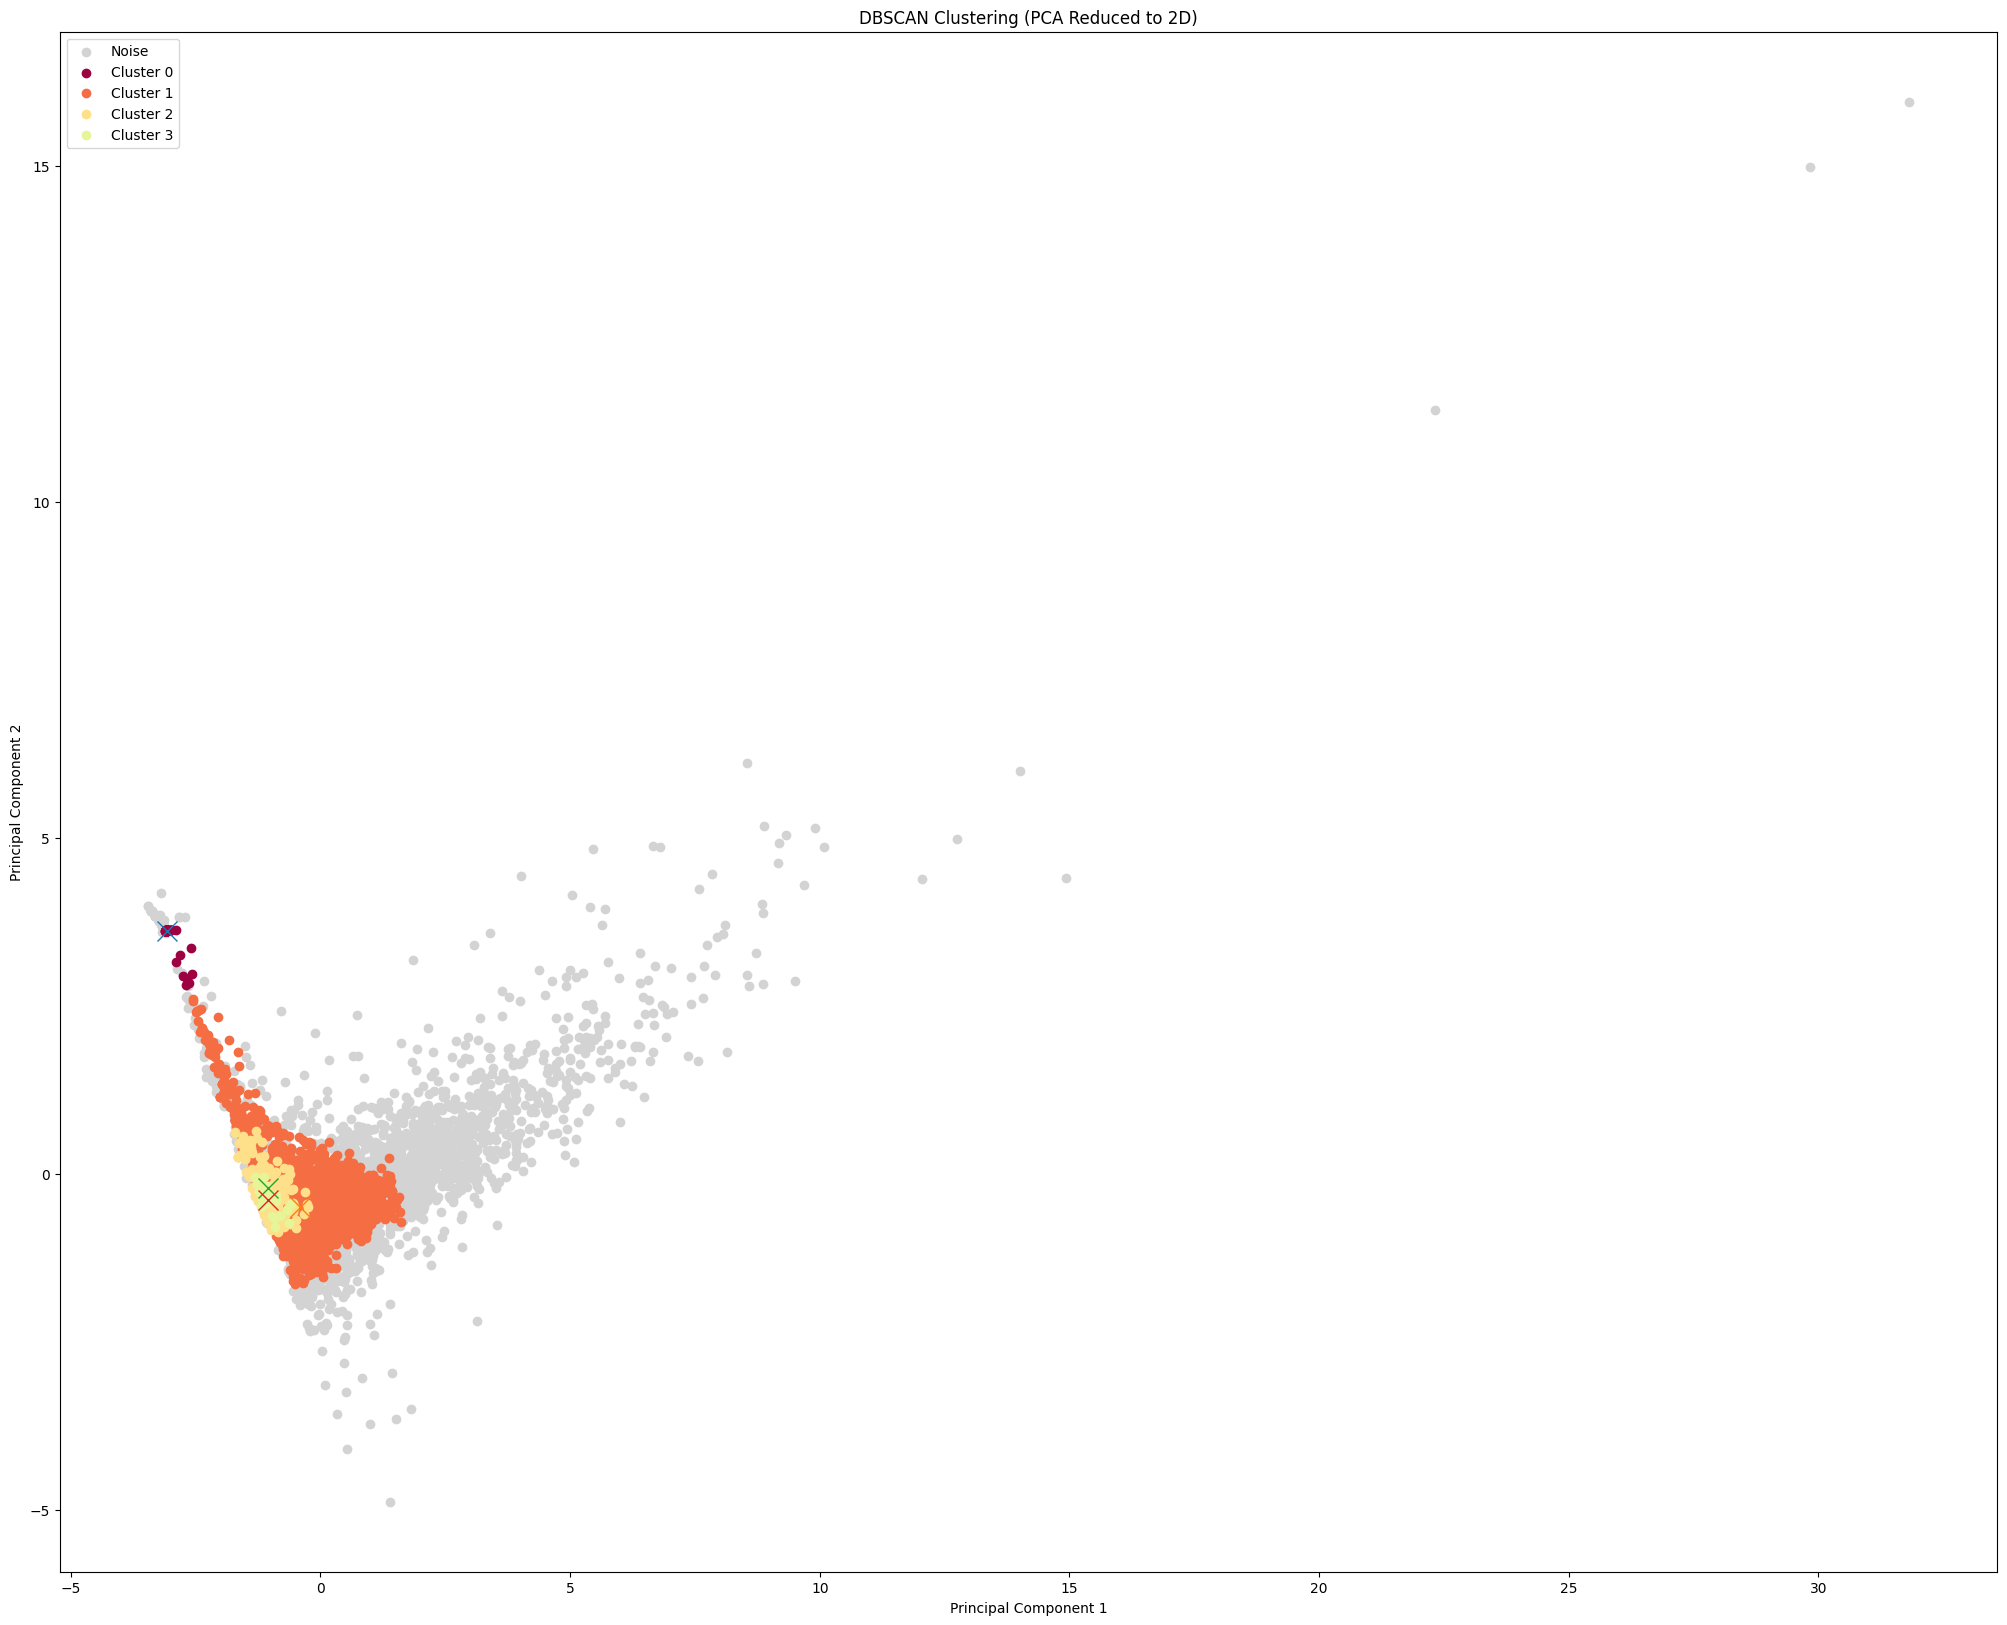

In [12]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Sample the data from df_num_pca
# sample_df = df_num_pca.sample(n=2000, random_state=42).reset_index(drop=True)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan_labels = dbscan.fit_predict(df_num_pca_inc_out)

# Number of clusters found (excluding noise)
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {dbscan_clusters}")

# Use the first two principal components from df_num_pca for visualization
dbscan_pca = df_num_pca_inc_out[['Principal Component 1', 'Principal Component 2']].values

# Plot the clusters
plt.figure(figsize=(25, 20))
# for k in set(dbscan_labels):
#     color = 'k' if k == -1 else plt.cm.Spectral(k / (dbscan_clusters + 1))  
#     plt.scatter(dbscan_pca[dbscan_labels == k, 0], dbscan_pca[dbscan_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')


noise_color = 'lightgray'
plt.scatter(dbscan_pca[dbscan_labels == -1, 0], dbscan_pca[dbscan_labels == -1, 1], color=noise_color, label='Noise')

for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        color = plt.cm.Spectral(k / (dbscan_clusters + 1))
        plt.scatter(dbscan_pca[dbscan_labels == k, 0], dbscan_pca[dbscan_labels == k, 1], color=color, label=f'Cluster {k}')

# Calculate and show cluster centroids using a black cross (X)
cluster_centers = []
for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        cluster_center = dbscan_pca[dbscan_labels == k].mean(axis=0)
        cluster_centers.append(cluster_center)
        plt.plot(cluster_center[0], cluster_center[1], 'x', markersize=15)

# Final plot additions
plt.title('DBSCAN Clustering (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Number of clusters found by BIRCH: 16


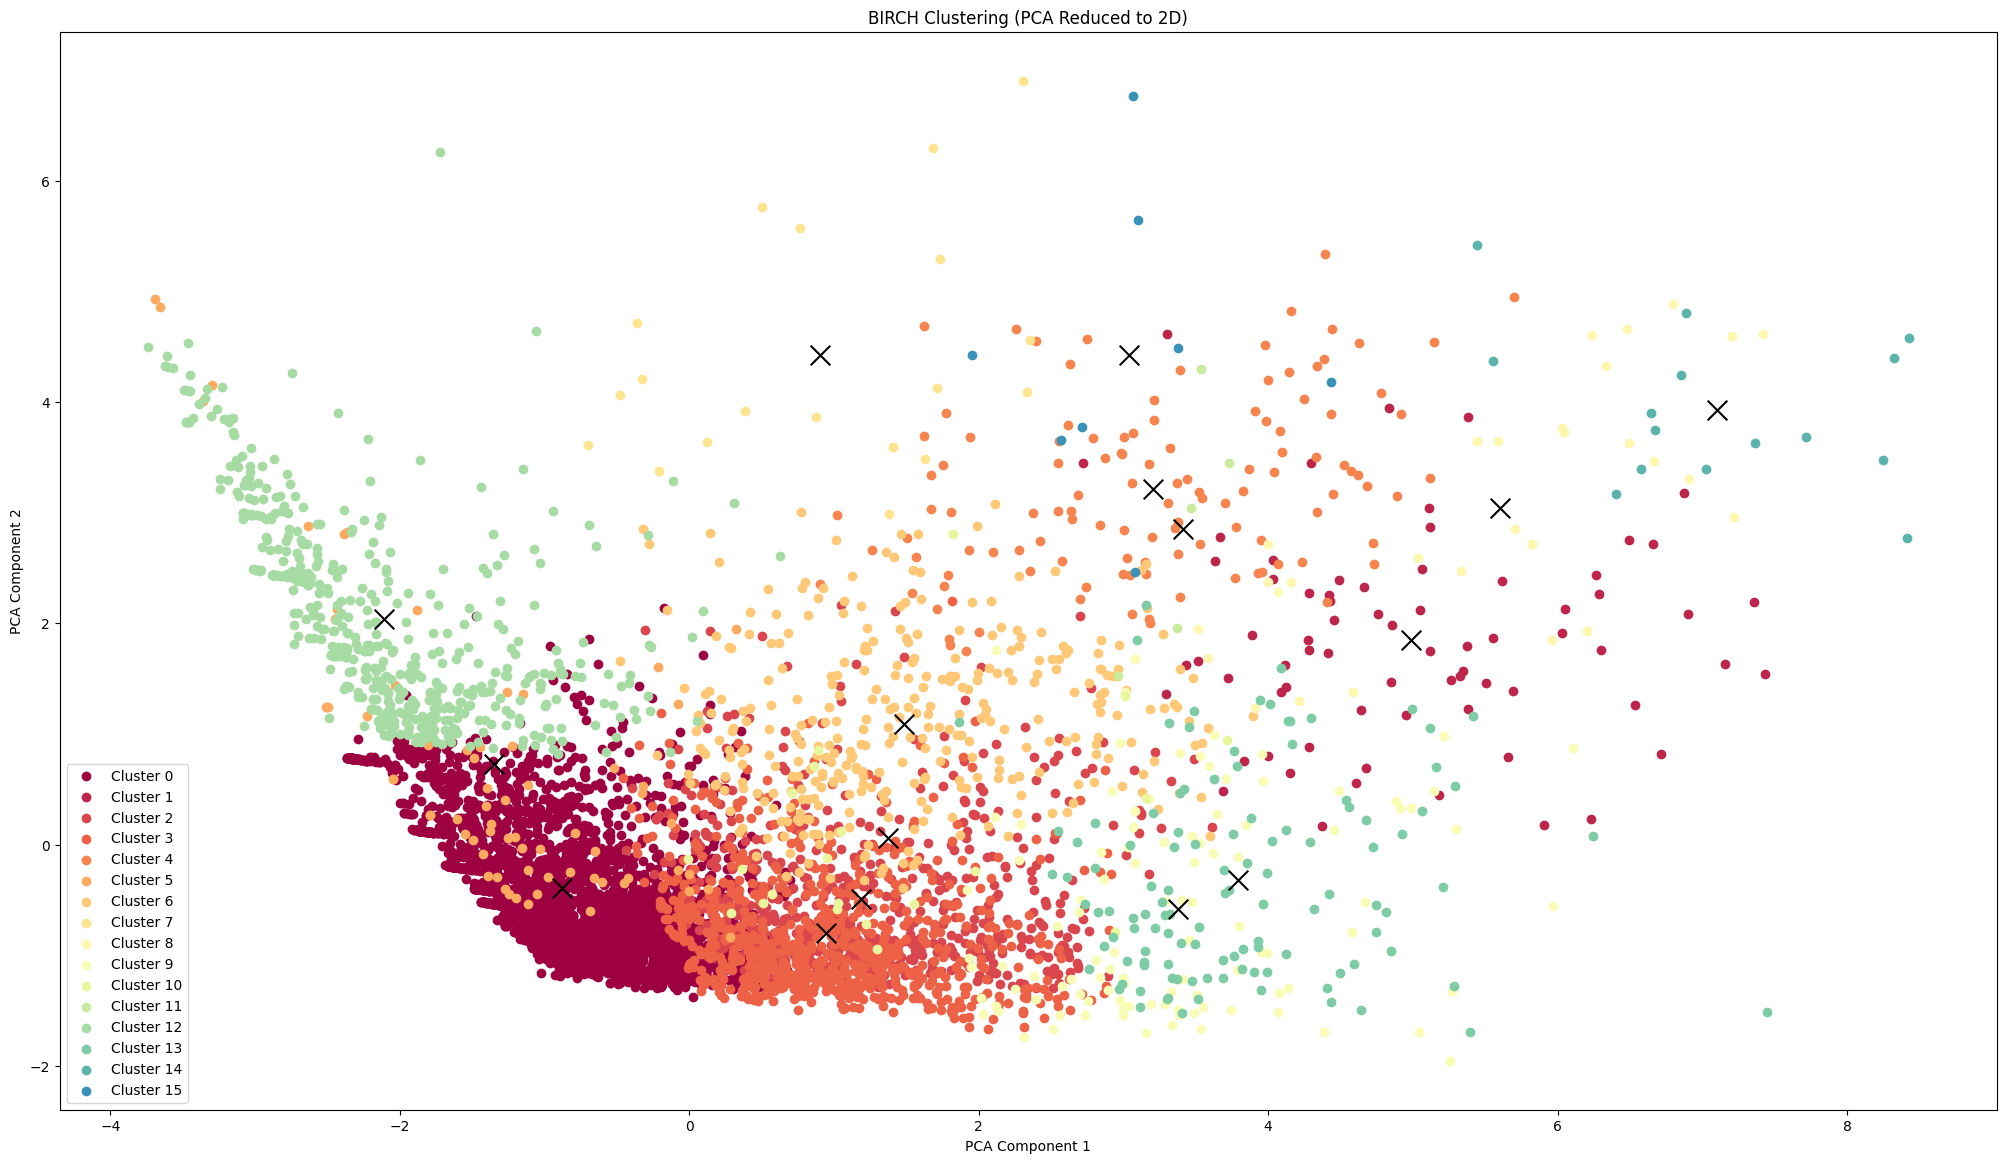

In [13]:
# Apply BIRCH
birch = Birch(n_clusters=None, threshold=2.5)  # Set n_clusters to None for no fixed number, threshold is the radius of the subcluster
birch_labels = birch.fit_predict(df_num_pca_rem_out)

# Number of clusters found (excluding noise)
birch_clusters = len(set(birch_labels)) - (1 if -1 in birch_labels else 0)
print(f"Number of clusters found by BIRCH: {birch_clusters}")


# Reduce to 2 dimensions using PCA for visualization
birch_pca = PCA(n_components=2).fit_transform(df_num_pca_rem_out)

# Plot the clusters
plt.figure(figsize=(25, 14))
for k in set(birch_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (birch_clusters + 1))  # Color for noise or other clusters
    plt.scatter(birch_pca[birch_labels == k, 0], birch_pca[birch_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Calculate and show cluster centroids using a black cross (X)
for k in set(birch_labels):
    if k != -1:  # Skip noise
        cluster_points = birch_pca[birch_labels == k]  # Points in the k-th cluster
        cluster_centroid = np.mean(cluster_points, axis=0)  # Calculate centroid
        plt.scatter(cluster_centroid[0], cluster_centroid[1], s=200, c='black', marker='x')

# Final plot additions
plt.title('BIRCH Clustering (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [14]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
Preference = [-80,-70, -60, -50, -40] 
silhouette_scores = [] 
for preference in Preference: 
    model = AffinityPropagation(preference=preference, random_state=42) 
    model.fit(df_num_pca_rem_out) 
      
    silhouette_scores.append(metrics.silhouette_score(df_num_pca_rem_out , model.labels_)) 
silhouette_scores 
  
# Create line plot of `Preference` vs `silhouette_scores` 
plt.plot(Preference , silhouette_scores ) 
plt.grid() 
plt.show()

KeyboardInterrupt: 

Number of clusters found by Affinity Propagation: 49


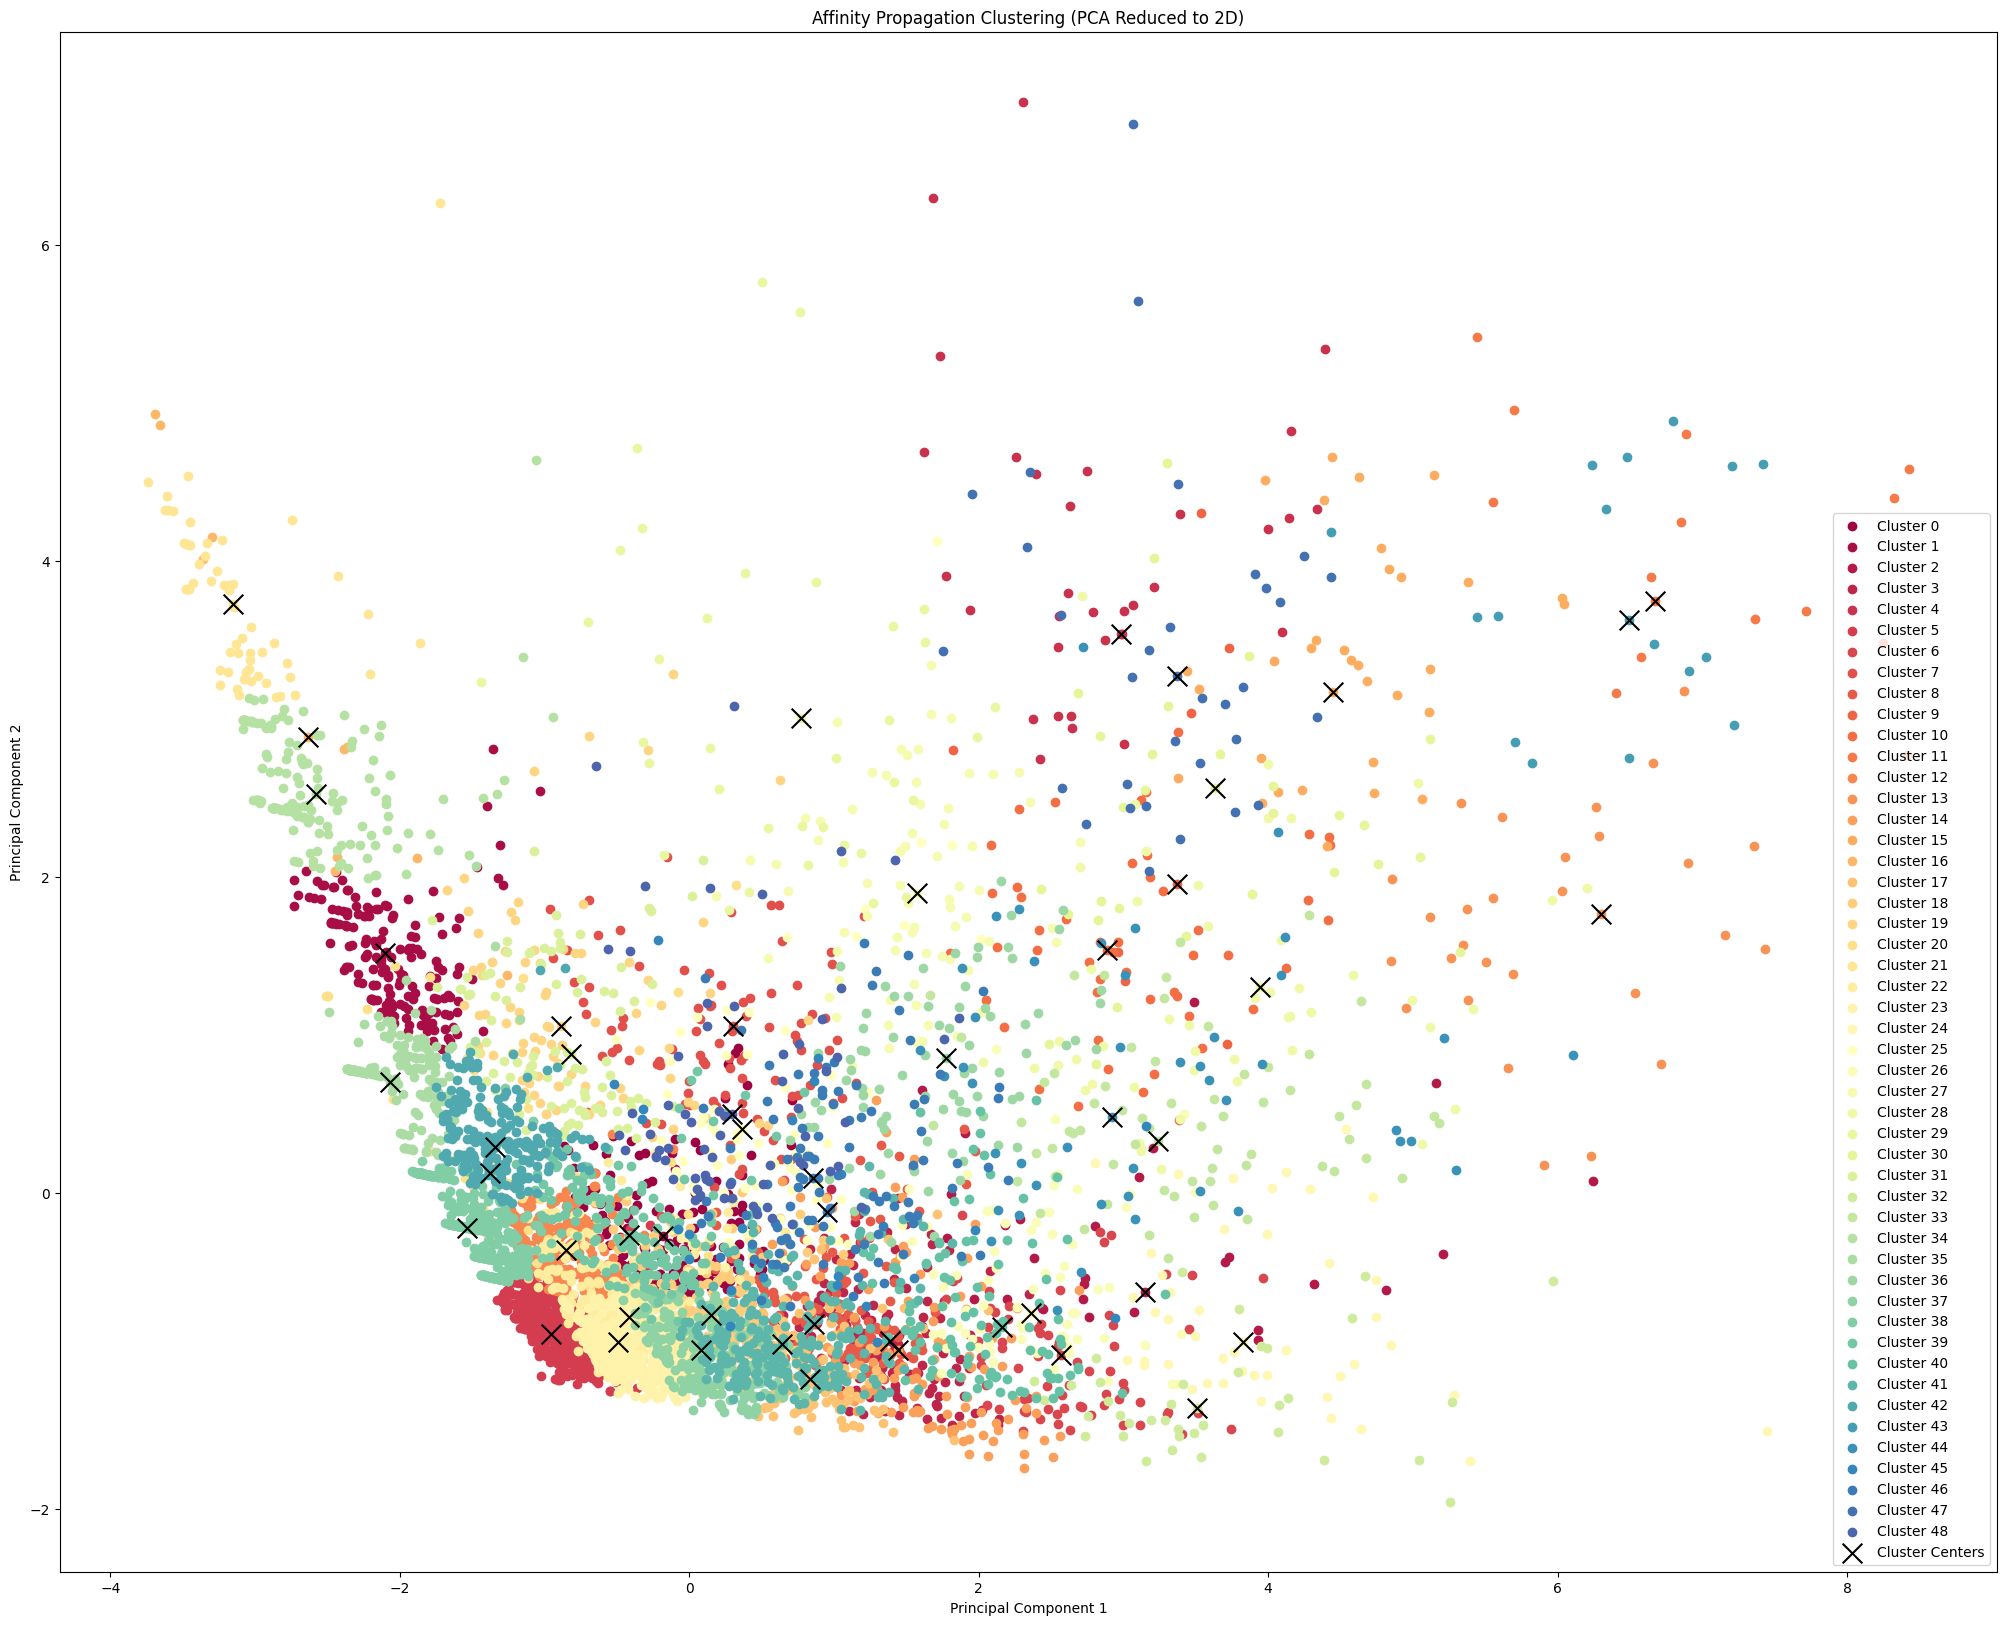

In [15]:
# Assuming you have already created df_num_pca using PCA
# Sample the data
# sample_df = df_num_pca.sample(n=2000, random_state=42).reset_index(drop=True)

# Apply Affinity Propagation
from sklearn.cluster import AffinityPropagation
afprop = AffinityPropagation(preference=-60, max_iter=500, damping=0.9, random_state=5)
afprop_labels = afprop.fit_predict(df_num_pca_rem_out)

# Number of clusters found (excluding noise)
afprop_clusters = len(set(afprop_labels)) - (1 if -1 in afprop_labels else 0)
print(f"Number of clusters found by Affinity Propagation: {afprop_clusters}")

# Reduce to 2 dimensions using PCA for visualization (already reduced in df_num_pca)
# Selecting the first two principal components for visualization
afprop_pca = df_num_pca_rem_out[['Principal Component 1', 'Principal Component 2']].values

# Plot the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 20))
for k in set(afprop_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (afprop_clusters + 1))  # Color for noise or other clusters
    plt.scatter(afprop_pca[afprop_labels == k, 0], afprop_pca[afprop_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Show the cluster centers
cluster_centers_indices = afprop.cluster_centers_indices_
if cluster_centers_indices is not None:
    cluster_centers = afprop.cluster_centers_
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='black', marker='x', label='Cluster Centers')

# Final plot additions
plt.title('Affinity Propagation Clustering (PCA Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



In [18]:
# Use Sklearn's Davies Bouldin Score to evaluate the results of all clustering models
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

db_score_dbscan = davies_bouldin_score(df_num_pca_inc_out, dbscan_labels)
print(f"Davies-Bouldin Score for DBSCAN: {db_score_dbscan}")

db_score_birch = davies_bouldin_score(df_num_pca_rem_out, birch_labels)
print(f"Davies-Bouldin Score for BIRCH: {db_score_birch}")

db_score_afprop = davies_bouldin_score(df_num_pca_rem_out, afprop_labels)
print(f"Davies-Bouldin Score for Affinity Propagation: {db_score_afprop}")

# Use Sklearn's Calinski-Harabasz Index to evaluate the results of all clustering models.
from sklearn.metrics import calinski_harabasz_score

ch_score_dbscan = calinski_harabasz_score(df_num_pca_inc_out, dbscan_labels)
print(f"Calinski-Harabasz Index for DBSCAN: {ch_score_dbscan}")

ch_score_birch = calinski_harabasz_score(df_num_pca_rem_out, birch_labels)
print(f"Calinski-Harabasz Index for BIRCH: {ch_score_birch}")

ch_score_afprop = calinski_harabasz_score(df_num_pca_rem_out, afprop_labels)
print(f"Calinski-Harabasz Index for Affinity Propagation: {ch_score_afprop}")

#4.1
# To show manual algorithm work we take a sample just to reduce running time
sample_df_inc_out = df_num_pca_inc_out.sample(n=2000, random_state=42).reset_index(drop=True)
sample_df_rem_out = df_num_pca_rem_out.sample(n=2000, random_state=42).reset_index(drop=True)

sample_dbscan = DBSCAN(eps=0.5, min_samples=30)
sample_dbscan_labels = sample_dbscan.fit_predict(sample_df_inc_out)
sample_birch = Birch(n_clusters=None, threshold=2.5)  # Set n_clusters to None for no fixed number, threshold is the radius of the subcluster
sample_birch_labels = sample_birch.fit_predict(sample_df_rem_out)
sample_afprop = AffinityPropagation(preference=-60, max_iter=500, damping=0.9, random_state=5)
sample_afprop_labels = sample_afprop.fit_predict(sample_df_rem_out)

# loop over all points in the same cluster and calculate average distance
def calculate_a(point_i, cluster, cluster_size):
  if cluster_size == 1:
    return 0
  total_distance = 0
  for j in range(len(cluster)):
    if point_i != j:
      total_distance += math.dist(cluster.iloc[point_i], cluster.iloc[j])
  return total_distance / (cluster_size-1)

# loop over all other_clusters, calculate average distance for each point in that other_cluster,
# take minimum distance for all the other_clusters
def calculate_b(point_i, cluster_i, cluster, cluster_datasets):
  b = float('inf')
  for other_cluster_j in cluster_datasets:
    if other_cluster_j == cluster_i:
      continue
    total_distance = 0
    other_cluster = cluster_datasets[other_cluster_j]
    for j in range(len(other_cluster)):
      total_distance += math.dist(cluster.iloc[point_i], other_cluster.iloc[j])
    avg_distance = total_distance / len(other_cluster)
    b = min(b, avg_distance)
  return b

def manual_silhouette_score(data, labels):
  labels_series = pd.Series(labels, index=data.index)
  # assigned all points to their respective cluster
  unique_clusters = set(labels) - {-1}
  k_clusters = len(unique_clusters)
  cluster_datasets = {}
  for cluster in unique_clusters:
    cluster_data = data[labels_series == cluster]
    cluster_datasets[cluster] = cluster_data
  # calculate silhouette_scores for each point that is in a cluster
  silhouette_scores = []
  for cluster in cluster_datasets:
    cluster_size = len(cluster_datasets[cluster])
    if cluster_size == 1:
      silhouette_scores.append(0)
      continue
    for point in range(len(cluster_datasets[cluster])):
      a = calculate_a(point, cluster_datasets[cluster], cluster_size)
      b = calculate_b(point, cluster, cluster_datasets[cluster], cluster_datasets)
      s = (b-a) / (max(a, b))
      silhouette_scores.append(s)
  # calculate silhouette coefficient by just taking the average of the silhouette score list
  silhouette_coefficient = sum(silhouette_scores) / len(silhouette_scores)
  return silhouette_coefficient

dbscan_manual_sil_score = manual_silhouette_score(sample_df_inc_out, sample_dbscan_labels)
print(f"Manually calculated silhouette score over sample dbscan: {dbscan_manual_sil_score}")
birch_manual_sil_score = manual_silhouette_score(sample_df_rem_out, sample_birch_labels)
print(f"Manually calculated silhouette score over sample birch: {birch_manual_sil_score}")
afprop_manual_sil_score = manual_silhouette_score(sample_df_rem_out, sample_afprop_labels)
print(f"Manually calculated silhouette score over sample affinity propagation: {afprop_manual_sil_score}")

dbscan_actual_sil_score = silhouette_score(df_num_pca_inc_out, dbscan_labels)
print(f"Actual dbscan silhoutte score: {dbscan_actual_sil_score}")
birch_actual_sil_score = silhouette_score(df_num_pca_rem_out, birch_labels)
print(f"Actual birch silhoutte score: {birch_actual_sil_score}")
afprop_actual_sil_score = silhouette_score(df_num_pca_rem_out, afprop_labels)
print(f"Actual affinity propagation silhoutte score: {afprop_actual_sil_score}")




Davies-Bouldin Score for DBSCAN: 1.3265850245277062
Davies-Bouldin Score for BIRCH: 1.104701727072077
Davies-Bouldin Score for Affinity Propagation: 1.0642883757972583
Calinski-Harabasz Index for DBSCAN: 728.4234356056752
Calinski-Harabasz Index for BIRCH: 1216.2603740968962
Calinski-Harabasz Index for Affinity Propagation: 1355.9993076592862
Manually calculated silhouette score over sample dbscan: 0.7788555273676585
Manually calculated silhouette score over sample birch: 0.3754970881855092
Manually calculated silhouette score over sample affinity propagation: 0.2648658920196083
Actual dbscan silhoutte score: 0.17774509784486608
Actual dbscan silhoutte score: 0.34070283044463723
Actual dbscan silhoutte score: 0.27020863479576773


FOR THE CLUSTERING METHODS USING PCA 

DBSCAN: This clustering method is useful to identify the outliers, so ideally we run it with df_num_inc_out

Birch: This clustering method is sensitive to the outliers, so we df_num_rem_out

Affinity Propagation: This clustering method is sensitive to the outliers, so we df_num_rem_out

NOW WE WILL USE THE dataframe with all the numerical variables to run the UMAP 

In [20]:
#Step 4 UMAP 
import umap.umap_ as umap

# Apply UMAP to df_out
umap_model_out = umap.UMAP(n_components=3)
df_rem_ump = umap_model_out.fit_transform(df_rem_out_samp)

# Apply UMAP to df_wout
umap_model_wout = umap.UMAP(n_components=3)
df_inc_ump = umap_model_wout.fit_transform(df_inc_out_samp)


c:\Users\daanv\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
import umap.umap_ as umap
from sklearn.manifold import trustworthiness

# Step 4: UMAP for df_out
umap_model_rem_out = umap.UMAP(n_components=3)
df_rem_ump = umap_model_rem_out.fit_transform(df_rem_out) 
# Step 4: UMAP for df_wout
umap_model_incl_out = umap.UMAP(n_components=3)
df_inc_ump = umap_model_incl_out.fit_transform(df_inc_out)  # Use the original df_wout

# Calculate trustworthiness score for df_out -> df_rem_ump
trustworthiness_out = trustworthiness(df_rem_out, df_rem_ump, n_neighbors=5)

# Calculate trustworthiness score for df_wout -> df_inc_ump
trustworthiness_wout = trustworthiness(df_inc_out, df_inc_ump, n_neighbors=5)

# Print trustworthiness scores
print(f"Trustworthiness of df_out UMAP: {trustworthiness_out:.4f}")
print(f"Trustworthiness of df_wout UMAP: {trustworthiness_wout:.4f}")


Trustworthiness of df_out UMAP: 0.9890
Trustworthiness of df_wout UMAP: 0.9876


Trustworthiness scores range from 0 to 1, where:

1 indicates perfect preservation of local structure (i.e., all nearest neighbors in the original space remain nearest neighbors in the reduced space).
0 indicates no preservation of the local structure at all.

TASK 3: CLUSTERING METHODS 

DBSCAN: This clustering method is useful to identify the outliers, so ideally we run it with df_inc_out_sampled

Birch: This clustering method is sensitive to the outliers, so we df_rem_out_sampled

Affinity Propagation: This clustering method is sensitive to the outliers, so we df_rem_out_sampled

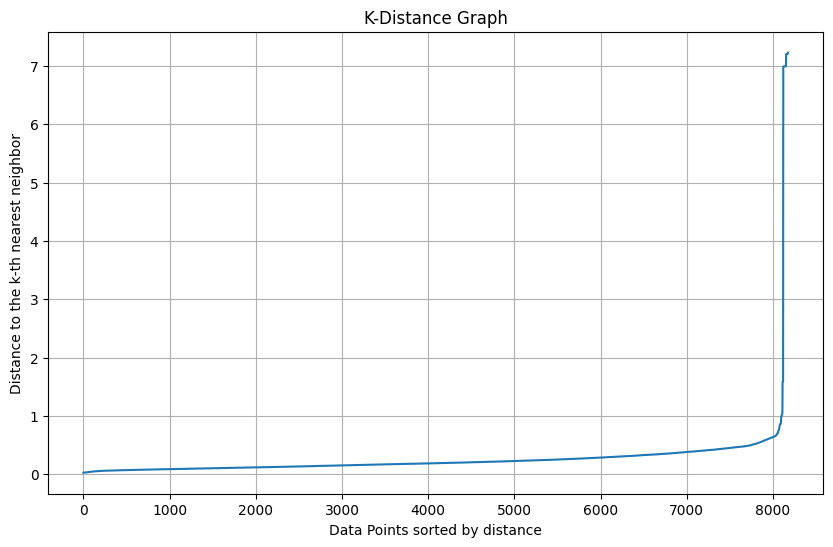

In [12]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_inc_ump is your data after UMAP reduction
min_samples = 30  # Set min_samples based on the guidelines

# Compute k-distances
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_inc_ump)
distances, indices = nbrs.kneighbors(df_inc_ump)

# Sort distances to plot
distances = np.sort(distances[:, min_samples - 1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Distance to the k-th nearest neighbor')
plt.grid()
plt.show()


Number of clusters found by DBSCAN: 17


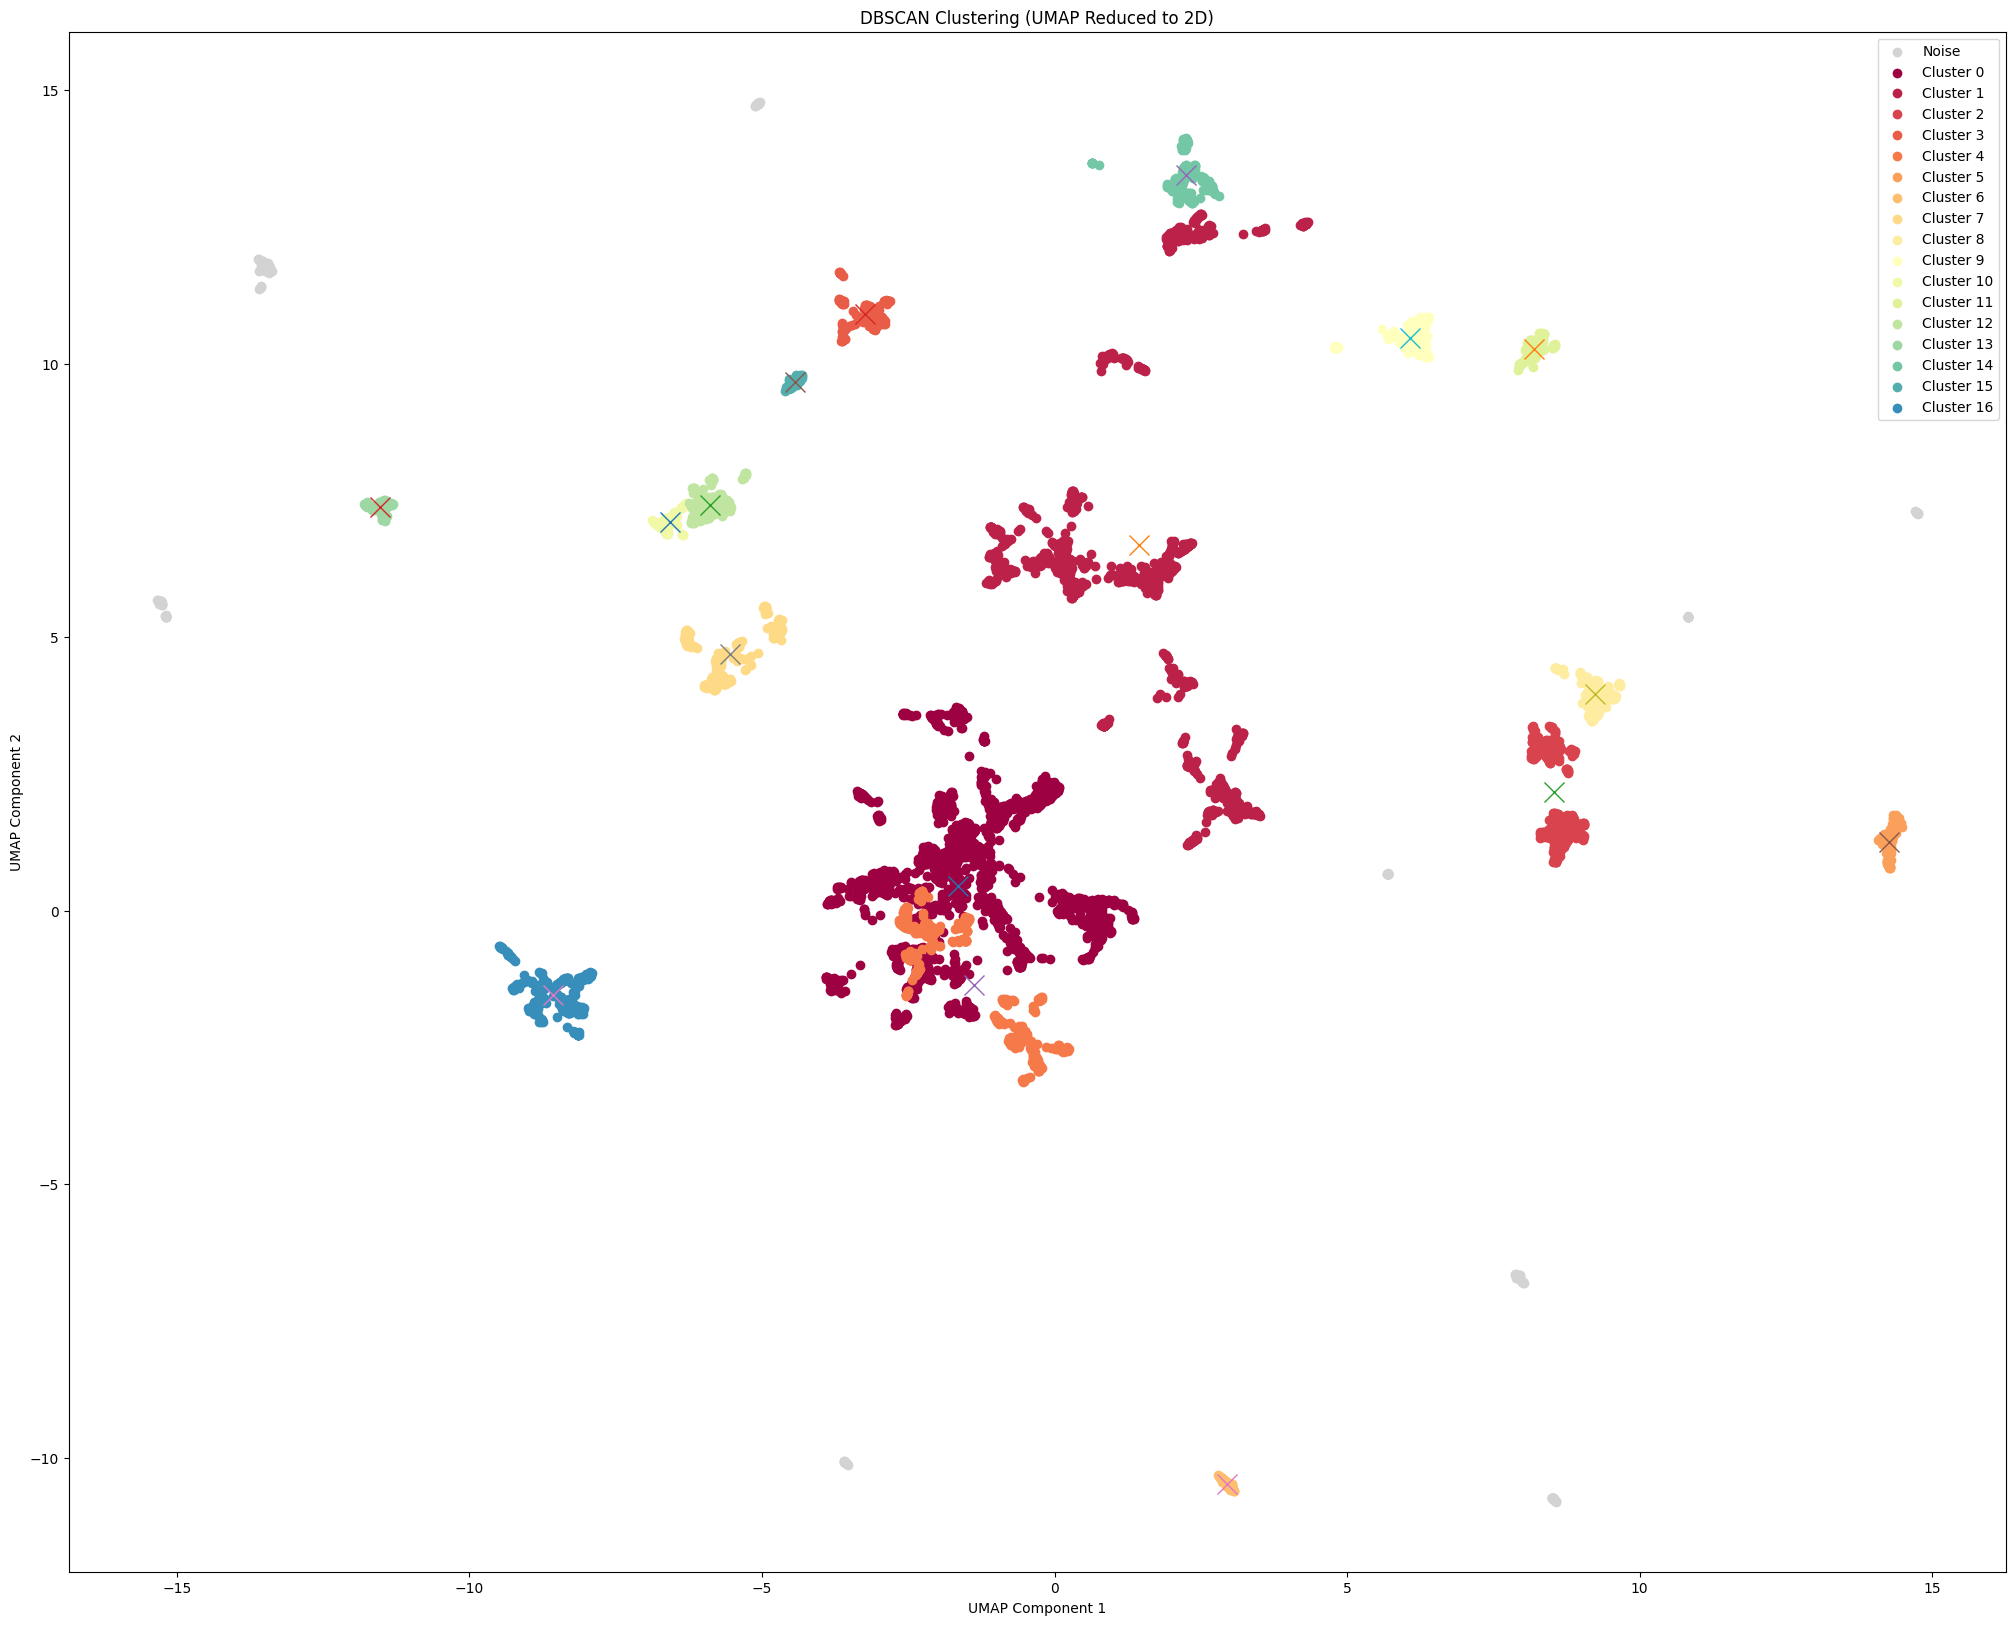

In [30]:
from sklearn.cluster import DBSCAN
# Apply DBSCAN
dbscan = DBSCAN(eps=3, min_samples=100)
dbscan_labels = dbscan.fit_predict(df_inc_ump)

# Number of clusters found (excluding noise)
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {dbscan_clusters}")

# Plot the clusters
plt.figure(figsize=(25, 20))
noise_color = 'lightgray'
plt.scatter(df_inc_ump[dbscan_labels == -1, 0], df_inc_ump[dbscan_labels == -1, 1], color=noise_color, label='Noise')

for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        color = plt.cm.Spectral(k / (dbscan_clusters + 1))
        plt.scatter(df_inc_ump[dbscan_labels == k, 0], df_inc_ump[dbscan_labels == k, 1], color=color, label=f'Cluster {k}')

# Calculate and show cluster centroids using a black cross (X)
cluster_centers = []
for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        cluster_center = df_inc_ump[dbscan_labels == k].mean(axis=0)
        cluster_centers.append(cluster_center)
        plt.plot(cluster_center[0], cluster_center[1], 'x', markersize=15)

# Final plot additions
plt.title('DBSCAN Clustering (UMAP Reduced to 2D)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()


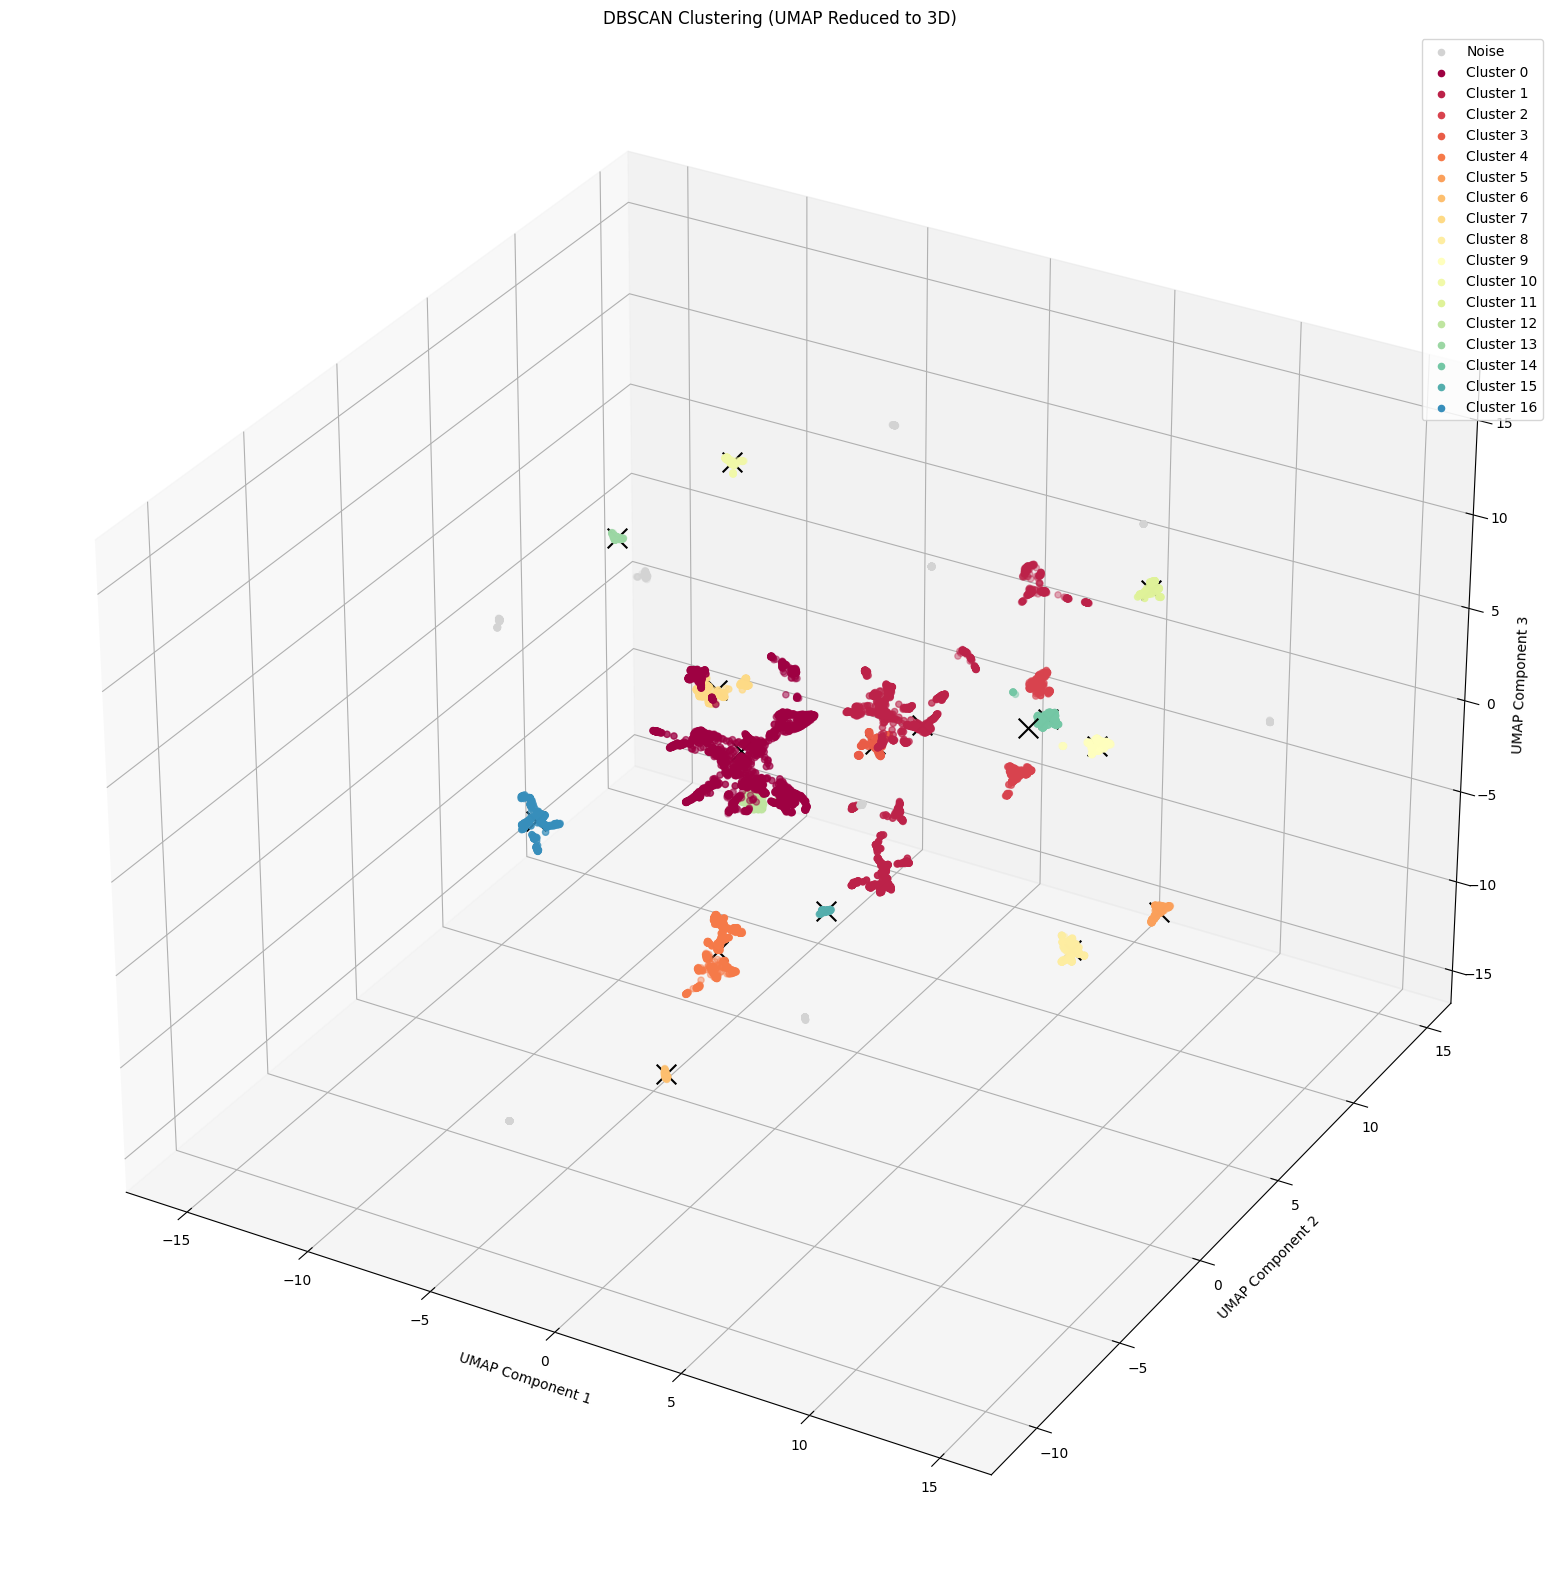

In [31]:
# Plot the clusters in 3D
fig = plt.figure(figsize=(25, 20))
ax = fig.add_subplot(111, projection='3d')

# Set colors for noise and clusters
noise_color = 'lightgray'
ax.scatter(df_inc_ump[dbscan_labels == -1, 0], df_inc_ump[dbscan_labels == -1, 1], df_inc_ump[dbscan_labels == -1, 2], color=noise_color, label='Noise')

for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        color = plt.cm.Spectral(k / (dbscan_clusters + 1))
        ax.scatter(df_inc_ump[dbscan_labels == k, 0], df_inc_ump[dbscan_labels == k, 1], df_inc_ump[dbscan_labels == k, 2], color=color, label=f'Cluster {k}')

# Calculate and show cluster centroids in 3D using a black cross (X)
cluster_centers = []
for k in set(dbscan_labels):
    if k != -1:  # Skip noise
        cluster_center = df_inc_ump[dbscan_labels == k].mean(axis=0)
        cluster_centers.append(cluster_center)
        ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], color='k', s=200, marker='x')  # Black cross for centroids

# Final plot additions
ax.set_title('DBSCAN Clustering (UMAP Reduced to 3D)')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.legend()
plt.show()

Number of clusters found by BIRCH: 11


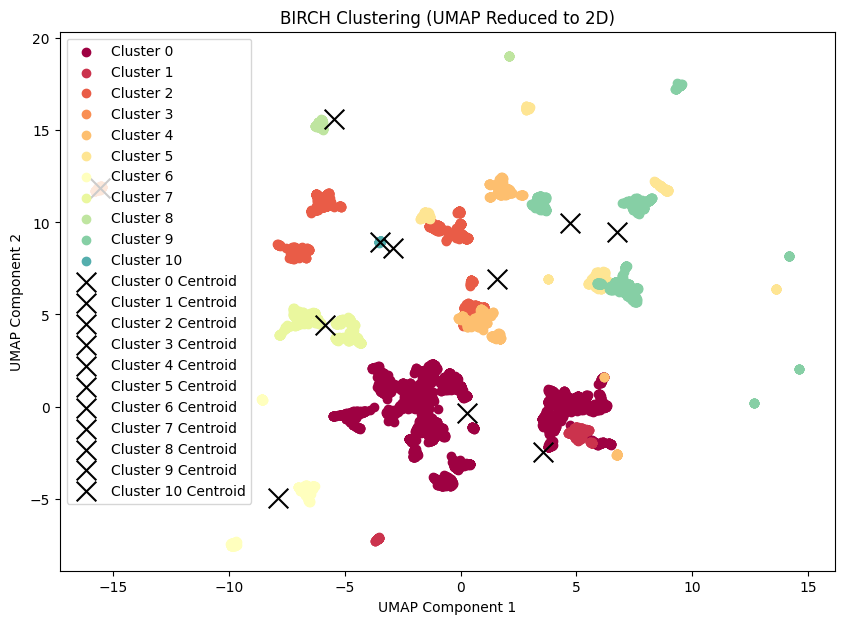

In [34]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
import numpy as np

# Apply BIRCH
birch = Birch(n_clusters=None, threshold=6)  # Set n_clusters to None for no fixed number
birch_labels = birch.fit_predict(df_rem_ump)

# Number of clusters found (excluding noise)
birch_clusters = len(set(birch_labels)) - (1 if -1 in birch_labels else 0)
print(f"Number of clusters found by BIRCH: {birch_clusters}")

# Plot the clusters in UMAP space
plt.figure(figsize=(10, 7))
for k in set(birch_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (birch_clusters + 1))  # Color for noise or other clusters
    plt.scatter(df_rem_ump[birch_labels == k, 0], df_rem_ump[birch_labels == k, 1], color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Calculate and show cluster centroids using a black cross (X)
for k in set(birch_labels):
    if k != -1:  # Skip noise
        cluster_points = df_rem_ump[birch_labels == k]  # Points in the k-th cluster
        cluster_centroid = np.mean(cluster_points, axis=0)  # Calculate centroid
        plt.scatter(cluster_centroid[0], cluster_centroid[1], s=200, c='black', marker='x', label=f'Cluster {k} Centroid')

# Final plot additions
plt.title('BIRCH Clustering (UMAP Reduced to 2D)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()


Number of clusters found by BIRCH: 11


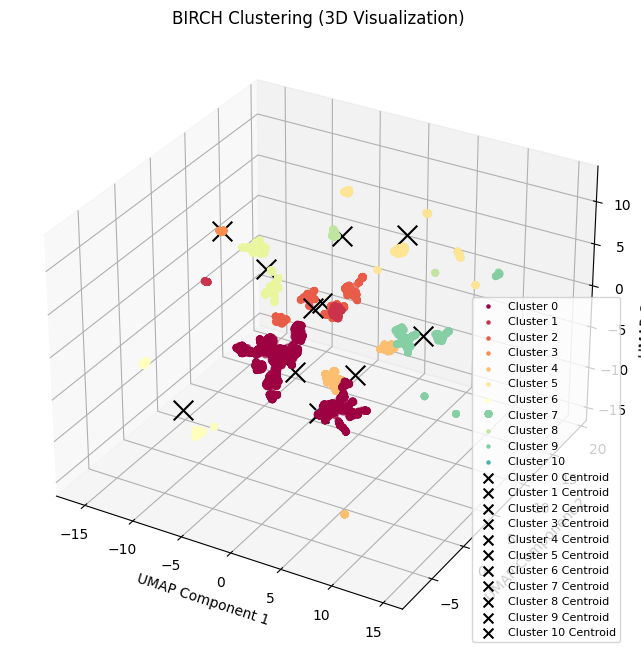

In [35]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming df_rem_ump is your UMAP reduced data (with 3 dimensions)
# Apply BIRCH with a suitable threshold
birch = Birch(n_clusters=None, threshold=6)  # Adjust threshold as needed
birch_labels = birch.fit_predict(df_rem_ump)

# Count clusters
birch_clusters = len(set(birch_labels)) - (1 if -1 in birch_labels else 0)
print(f"Number of clusters found by BIRCH: {birch_clusters}")

# 3D Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for clusters
for k in set(birch_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (birch_clusters + 1))
    ax.scatter(df_rem_ump[birch_labels == k, 0], df_rem_ump[birch_labels == k, 1], df_rem_ump[birch_labels == k, 2], 
               color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Calculate and show cluster centroids
for k in set(birch_labels):
    if k != -1:
        cluster_points = df_rem_ump[birch_labels == k]
        cluster_centroid = np.mean(cluster_points, axis=0)
        ax.scatter(cluster_centroid[0], cluster_centroid[1], cluster_centroid[2], 
                   s=200, c='black', marker='x', label=f'Cluster {k} Centroid')

# Final plot additions
ax.set_title('BIRCH Clustering (3D Visualization)')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')

# Adjust legend properties
ax.legend(loc='best', fontsize=8, markerscale=0.5)  # Set fontsize to a specific number for smaller text
plt.show()


Number of clusters found by Affinity Propagation: 72


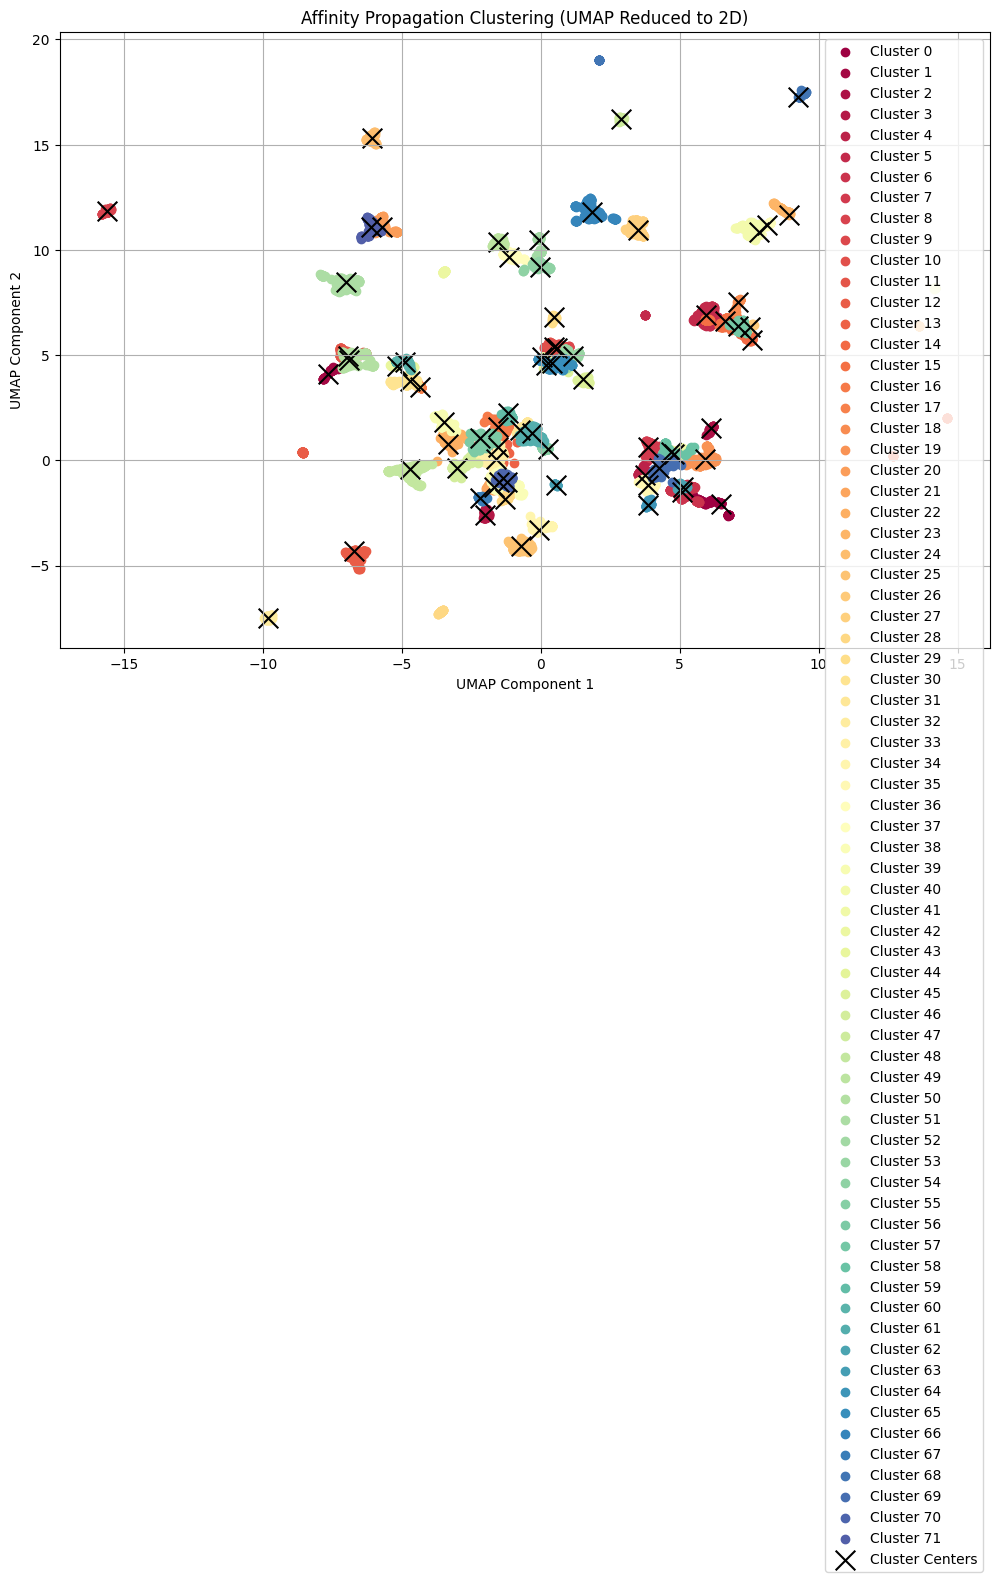

In [48]:
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt

afprop = AffinityPropagation (preference = -30, max_iter=500, damping=.99, random_state=5)
afprop_labels = afprop.fit_predict(df_rem_ump)

# Number of clusters found (excluding noise)
afprop_clusters = len(set(afprop_labels)) - (1 if -1 in afprop_labels else 0)
print(f"Number of clusters found by Affinity Propagation: {afprop_clusters}")

# Check if the data is 2D or 3D
if df_rem_ump.shape[1] == 2:
    afprop_2d = df_rem_ump  # Already in 2D
elif df_rem_ump.shape[1] == 3:
    afprop_2d = df_rem_ump[:, :2]  # Take the first two components for 2D visualization
else:
    raise ValueError("df_rem_ump must be 2D or 3D for visualization.")

# Plot the clusters
plt.figure(figsize=(12, 8))
for k in set(afprop_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (afprop_clusters + 1))  # Color for noise or other clusters
    plt.scatter(afprop_2d[afprop_labels == k, 0], afprop_2d[afprop_labels == k, 1], 
                color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Show the cluster centers if available
if hasattr(afprop, 'cluster_centers_'):
    cluster_centers = afprop.cluster_centers_
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='black', marker='x', label='Cluster Centers')

# Final plot additions
plt.title('Affinity Propagation Clustering (UMAP Reduced to 2D)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid()
plt.show()


In [23]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import matplotlib.pyplot as plt

# Assuming df_rem_ump is your UMAP reduced dataset (must be 2D or 3D)

# Define preference values to test
Preference = [-50, -40, -30, -20, -10]
silhouette_scores = []

# Iterate over each preference value
for preference in Preference:
    # Apply Affinity Propagation with the current preference
    afprop = AffinityPropagation(preference = -30, max_iter=500, damping=.99, random_state=5)
    afprop_labels = afprop.fit_predict(df_rem_ump)
    
    # Calculate the silhouette score and append it to the list
    if len(set(afprop_labels)) > 1:  # Check if there is more than one cluster
        score = metrics.silhouette_score(df_rem_ump, afprop_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Append -1 if there is only one cluster

# Plot silhouette scores vs. preference
plt.figure(figsize=(10, 6))
plt.plot(Preference, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Preference Values')
plt.xlabel('Preference Value')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Optionally, print the best preference based on the highest silhouette score
best_index = silhouette_scores.index(max(silhouette_scores))
best_preference = Preference[best_index]
print(f"Best preference value: {best_preference} with a silhouette score of {silhouette_scores[best_index]}")


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Number of clusters found by Affinity Propagation: 86


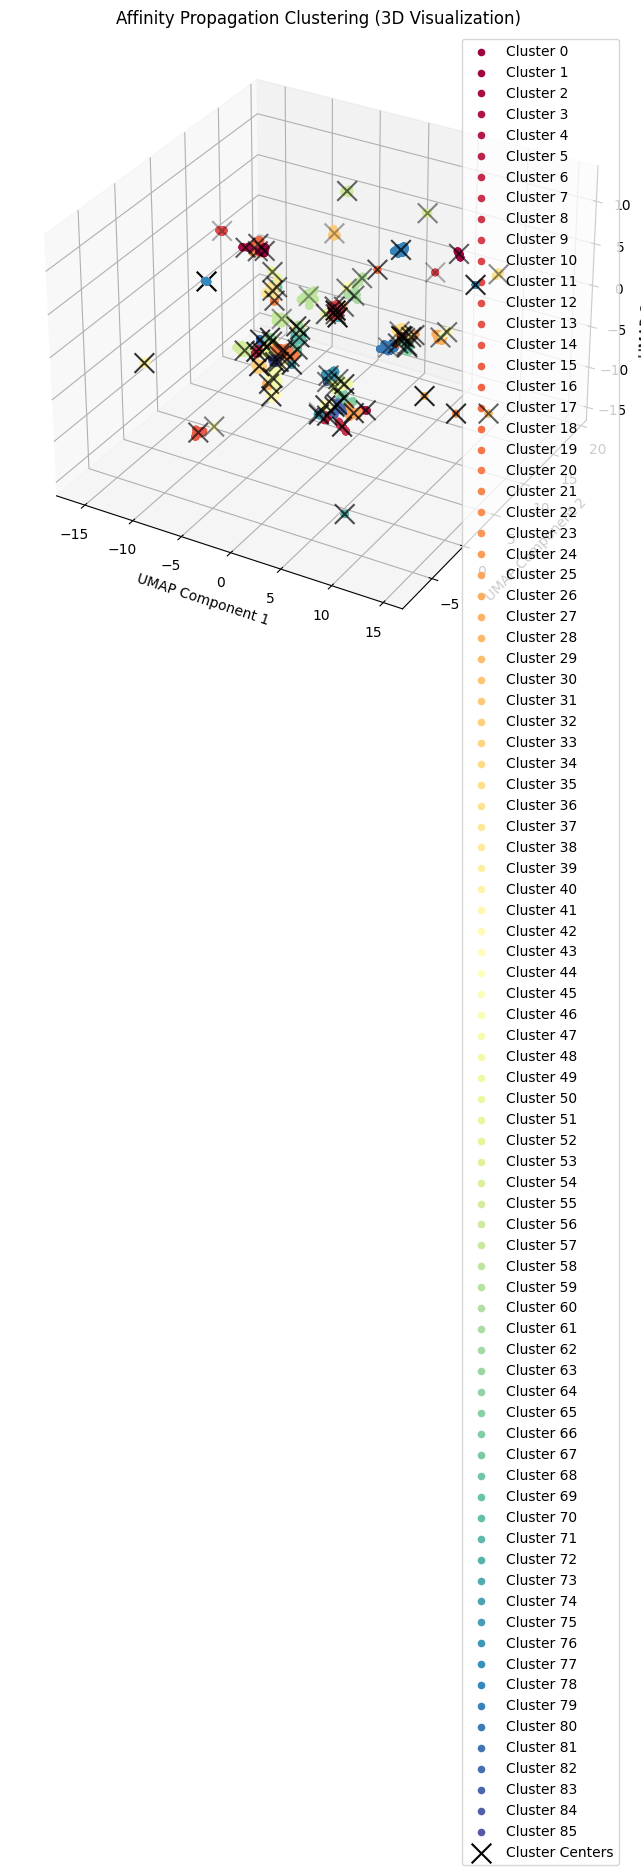

In [41]:
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df_rem_ump is your UMAP reduced dataset (must be 3D)
# Apply Affinity Propagation
afprop = AffinityPropagation(preference = -30, max_iter=500, damping=.99, random_state=5)  # Increase preference

afprop_labels = afprop.fit_predict(df_rem_ump)

# Number of clusters found (excluding noise)
afprop_clusters = len(set(afprop_labels)) - (1 if -1 in afprop_labels else 0)
print(f"Number of clusters found by Affinity Propagation: {afprop_clusters}")

# Plot the clusters in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for clusters
for k in set(afprop_labels):
    color = 'k' if k == -1 else plt.cm.Spectral(k / (afprop_clusters + 1))  # Color for noise or other clusters
    ax.scatter(df_rem_ump[afprop_labels == k, 0], 
               df_rem_ump[afprop_labels == k, 1], 
               df_rem_ump[afprop_labels == k, 2], 
               color=color, label=f'Cluster {k}' if k != -1 else 'Noise')

# Show the cluster centers if available
if hasattr(afprop, 'cluster_centers_'):
    cluster_centers = afprop.cluster_centers_
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], 
               s=200, c='black', marker='x', label='Cluster Centers')

# Final plot additions
ax.set_title('Affinity Propagation Clustering (3D Visualization)')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.legend()
plt.show()


In [49]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, Birch, AffinityPropagation

# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=100)
dbscan_labels = dbscan.fit_predict(df_inc_ump)

# Number of clusters found (excluding noise)
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {dbscan_clusters}")

# Silhouette Score for DBSCAN
if dbscan_clusters > 1:  # Check if there are at least 2 clusters
    dbscan_silhouette = silhouette_score(df_inc_ump, dbscan_labels)
    print(f"Silhouette Score for DBSCAN: {dbscan_silhouette}")
else:
    print("Silhouette Score for DBSCAN: Not applicable (only one cluster)")

# BIRCH
birch = Birch(n_clusters=None, threshold=6)
birch_labels = birch.fit_predict(df_rem_ump)

# Number of clusters found (excluding noise)
birch_clusters = len(set(birch_labels)) - (1 if -1 in birch_labels else 0)
print(f"Number of clusters found by BIRCH: {birch_clusters}")

# Silhouette Score for BIRCH
if birch_clusters > 1:  # Check if there are at least 2 clusters
    birch_silhouette = silhouette_score(df_rem_ump, birch_labels)
    print(f"Silhouette Score for BIRCH: {birch_silhouette}")
else:
    print("Silhouette Score for BIRCH: Not applicable (only one cluster)")

# Affinity Propagation
afprop = AffinityPropagation(preference=-30, max_iter=500, damping=.99, random_state=5)
afprop_labels = afprop.fit_predict(df_rem_ump)

# Number of clusters found (excluding noise)
afprop_clusters = len(set(afprop_labels)) - (1 if -1 in afprop_labels else 0)
print(f"Number of clusters found by Affinity Propagation: {afprop_clusters}")

# Silhouette Score for Affinity Propagation
if afprop_clusters > 1:  # Check if there are at least 2 clusters
    afprop_silhouette = silhouette_score(df_rem_ump, afprop_labels)
    print(f"Silhouette Score for Affinity Propagation: {afprop_silhouette}")
else:
    print("Silhouette Score for Affinity Propagation: Not applicable (only one cluster)")

# Use Sklearn's Davies-Bouldin Score to evaluate the results of all clustering models
db_score_afprop = davies_bouldin_score(df_rem_ump, afprop_labels)
print(f"Davies-Bouldin Score for Affinity Propagation: {db_score_afprop}")

db_score_dbscan = davies_bouldin_score(df_rem_ump, dbscan_labels)
print(f"Davies-Bouldin Score for DBSCAN: {db_score_dbscan}")

db_score_birch = davies_bouldin_score(df_rem_ump, birch_labels)
print(f"Davies-Bouldin Score for BIRCH: {db_score_birch}")

# Use Sklearn's Calinski-Harabasz Index to evaluate the results of all clustering models.
ch_score_afprop = calinski_harabasz_score(df_rem_ump, afprop_labels)
print(f"\nCalinski-Harabasz Index for Affinity Propagation: {ch_score_afprop}")

ch_score_dbscan = calinski_harabasz_score(df_rem_ump, dbscan_labels)
print(f"Calinski-Harabasz Index for DBSCAN: {ch_score_dbscan}")

ch_score_birch = calinski_harabasz_score(df_rem_ump, birch_labels)
print(f"Calinski-Harabasz Index for BIRCH: {ch_score_birch}")


Number of clusters found by DBSCAN: 17
Silhouette Score for DBSCAN: 0.528546929359436
Number of clusters found by BIRCH: 11
Silhouette Score for BIRCH: 0.43986544013023376
Number of clusters found by Affinity Propagation: 72
Silhouette Score for Affinity Propagation: 0.6032553315162659
Davies-Bouldin Score for Affinity Propagation: 0.7935981330785664
Davies-Bouldin Score for DBSCAN: 2.2994384853813314
Davies-Bouldin Score for BIRCH: 0.8190850902356555

Calinski-Harabasz Index for Affinity Propagation: 5148.704467581543
Calinski-Harabasz Index for DBSCAN: 1013.5245999057868
Calinski-Harabasz Index for BIRCH: 2715.838660625951


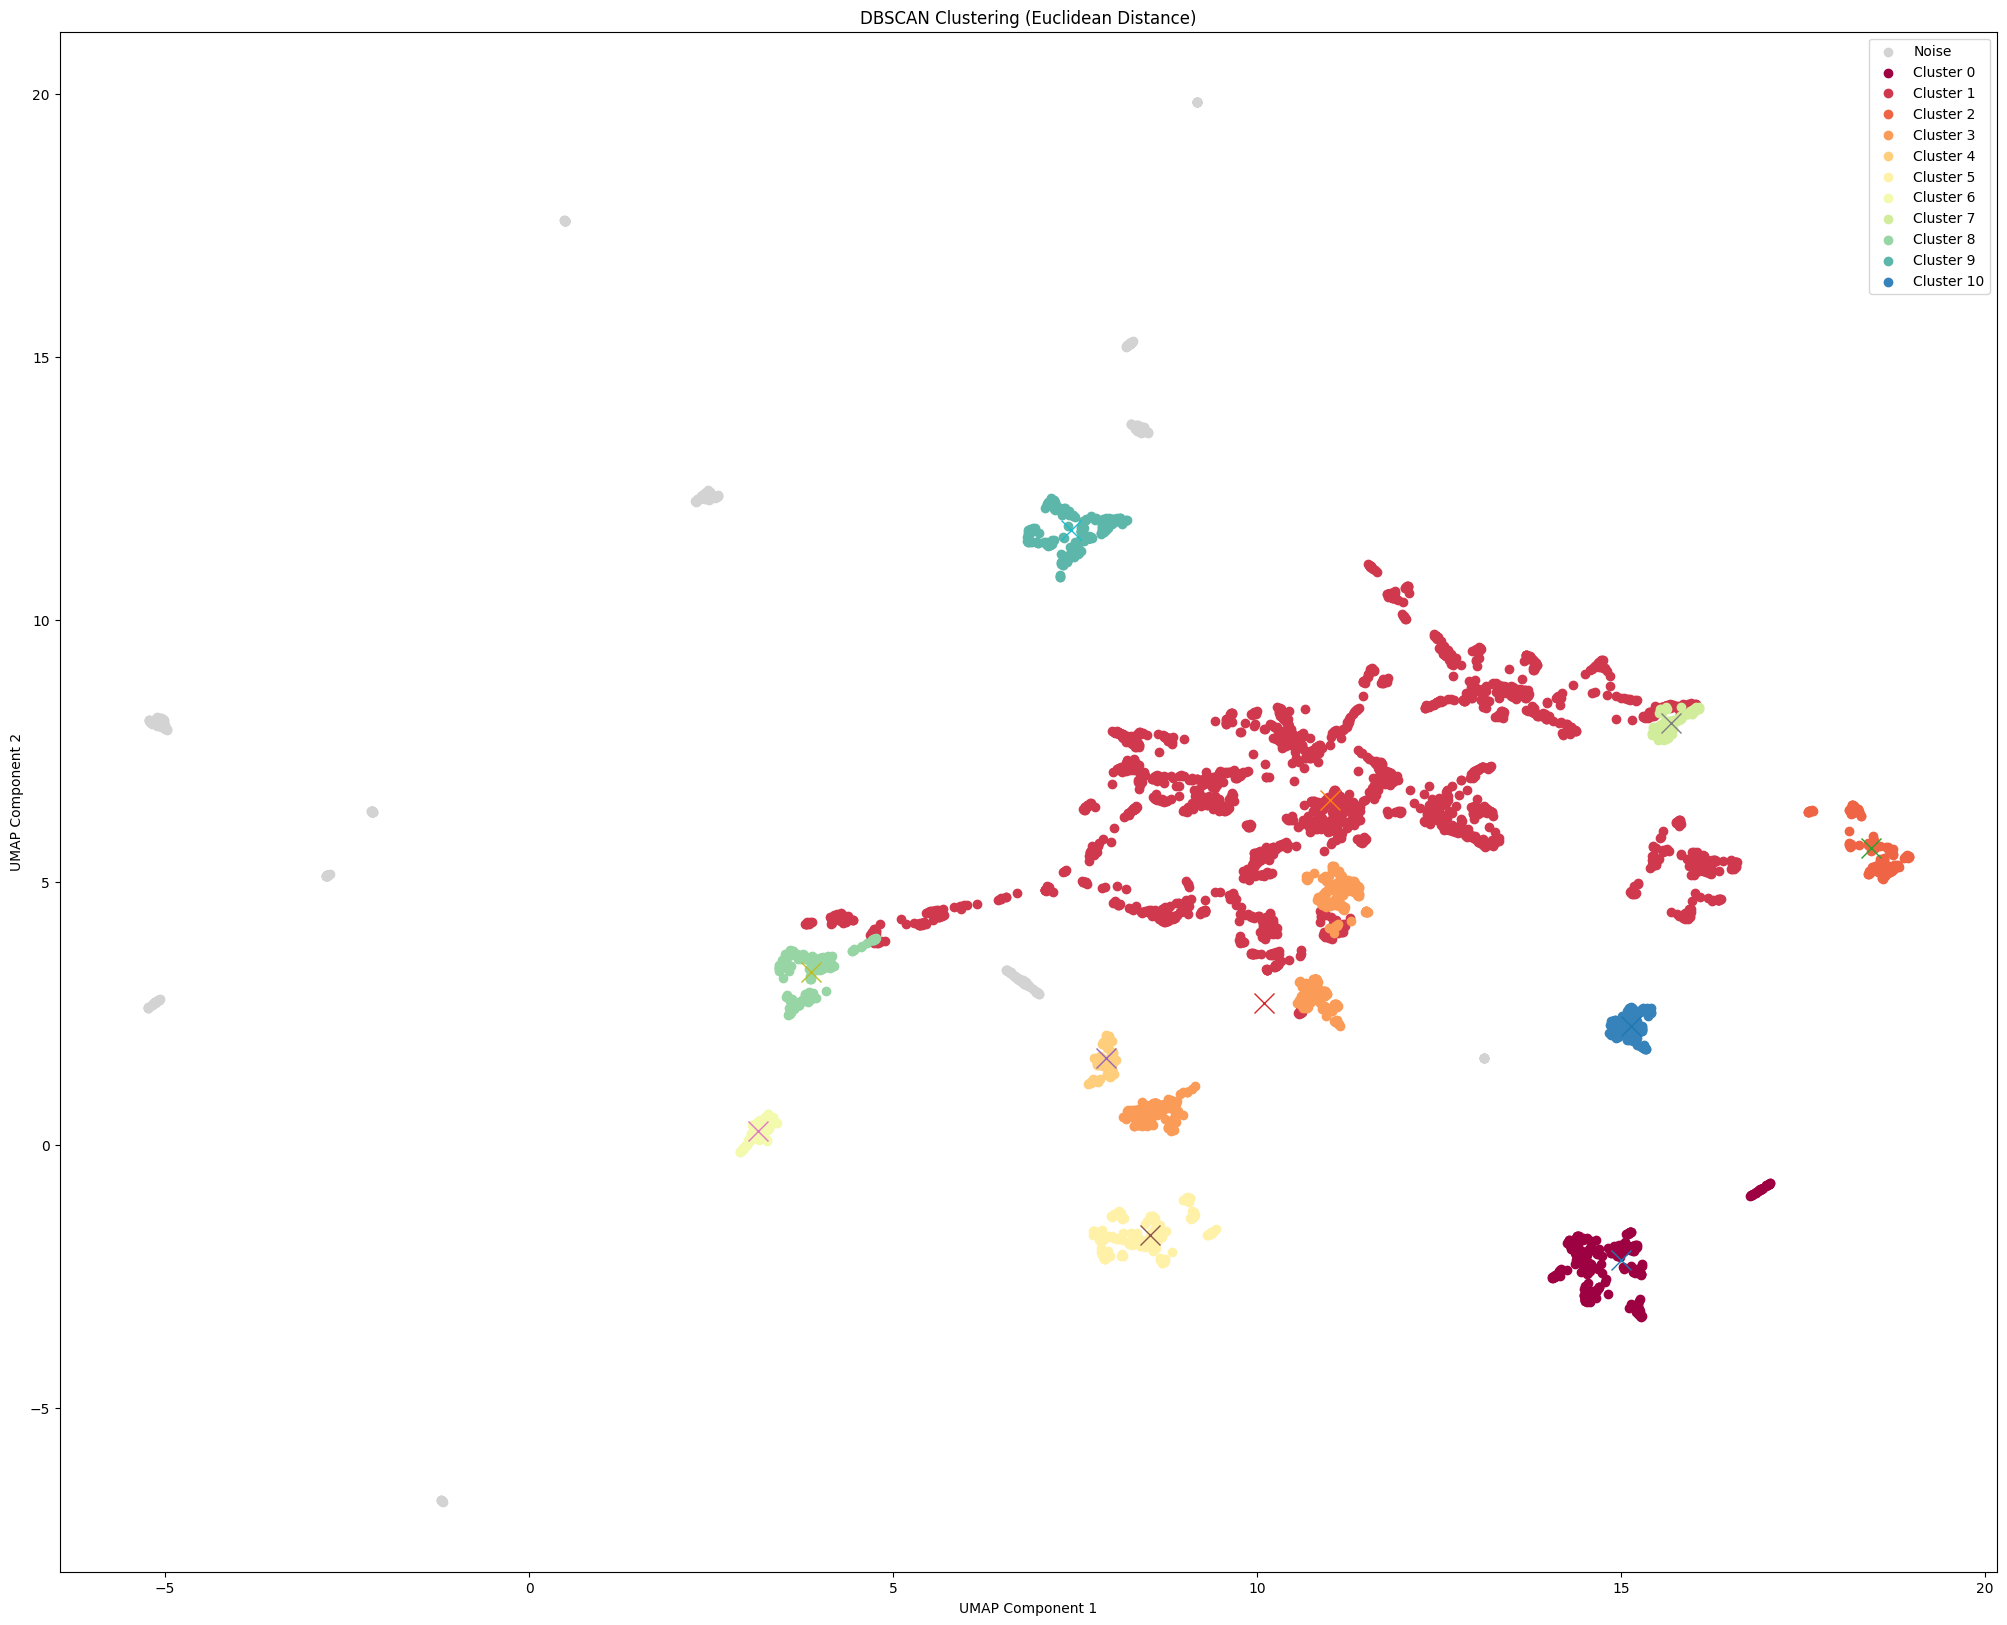

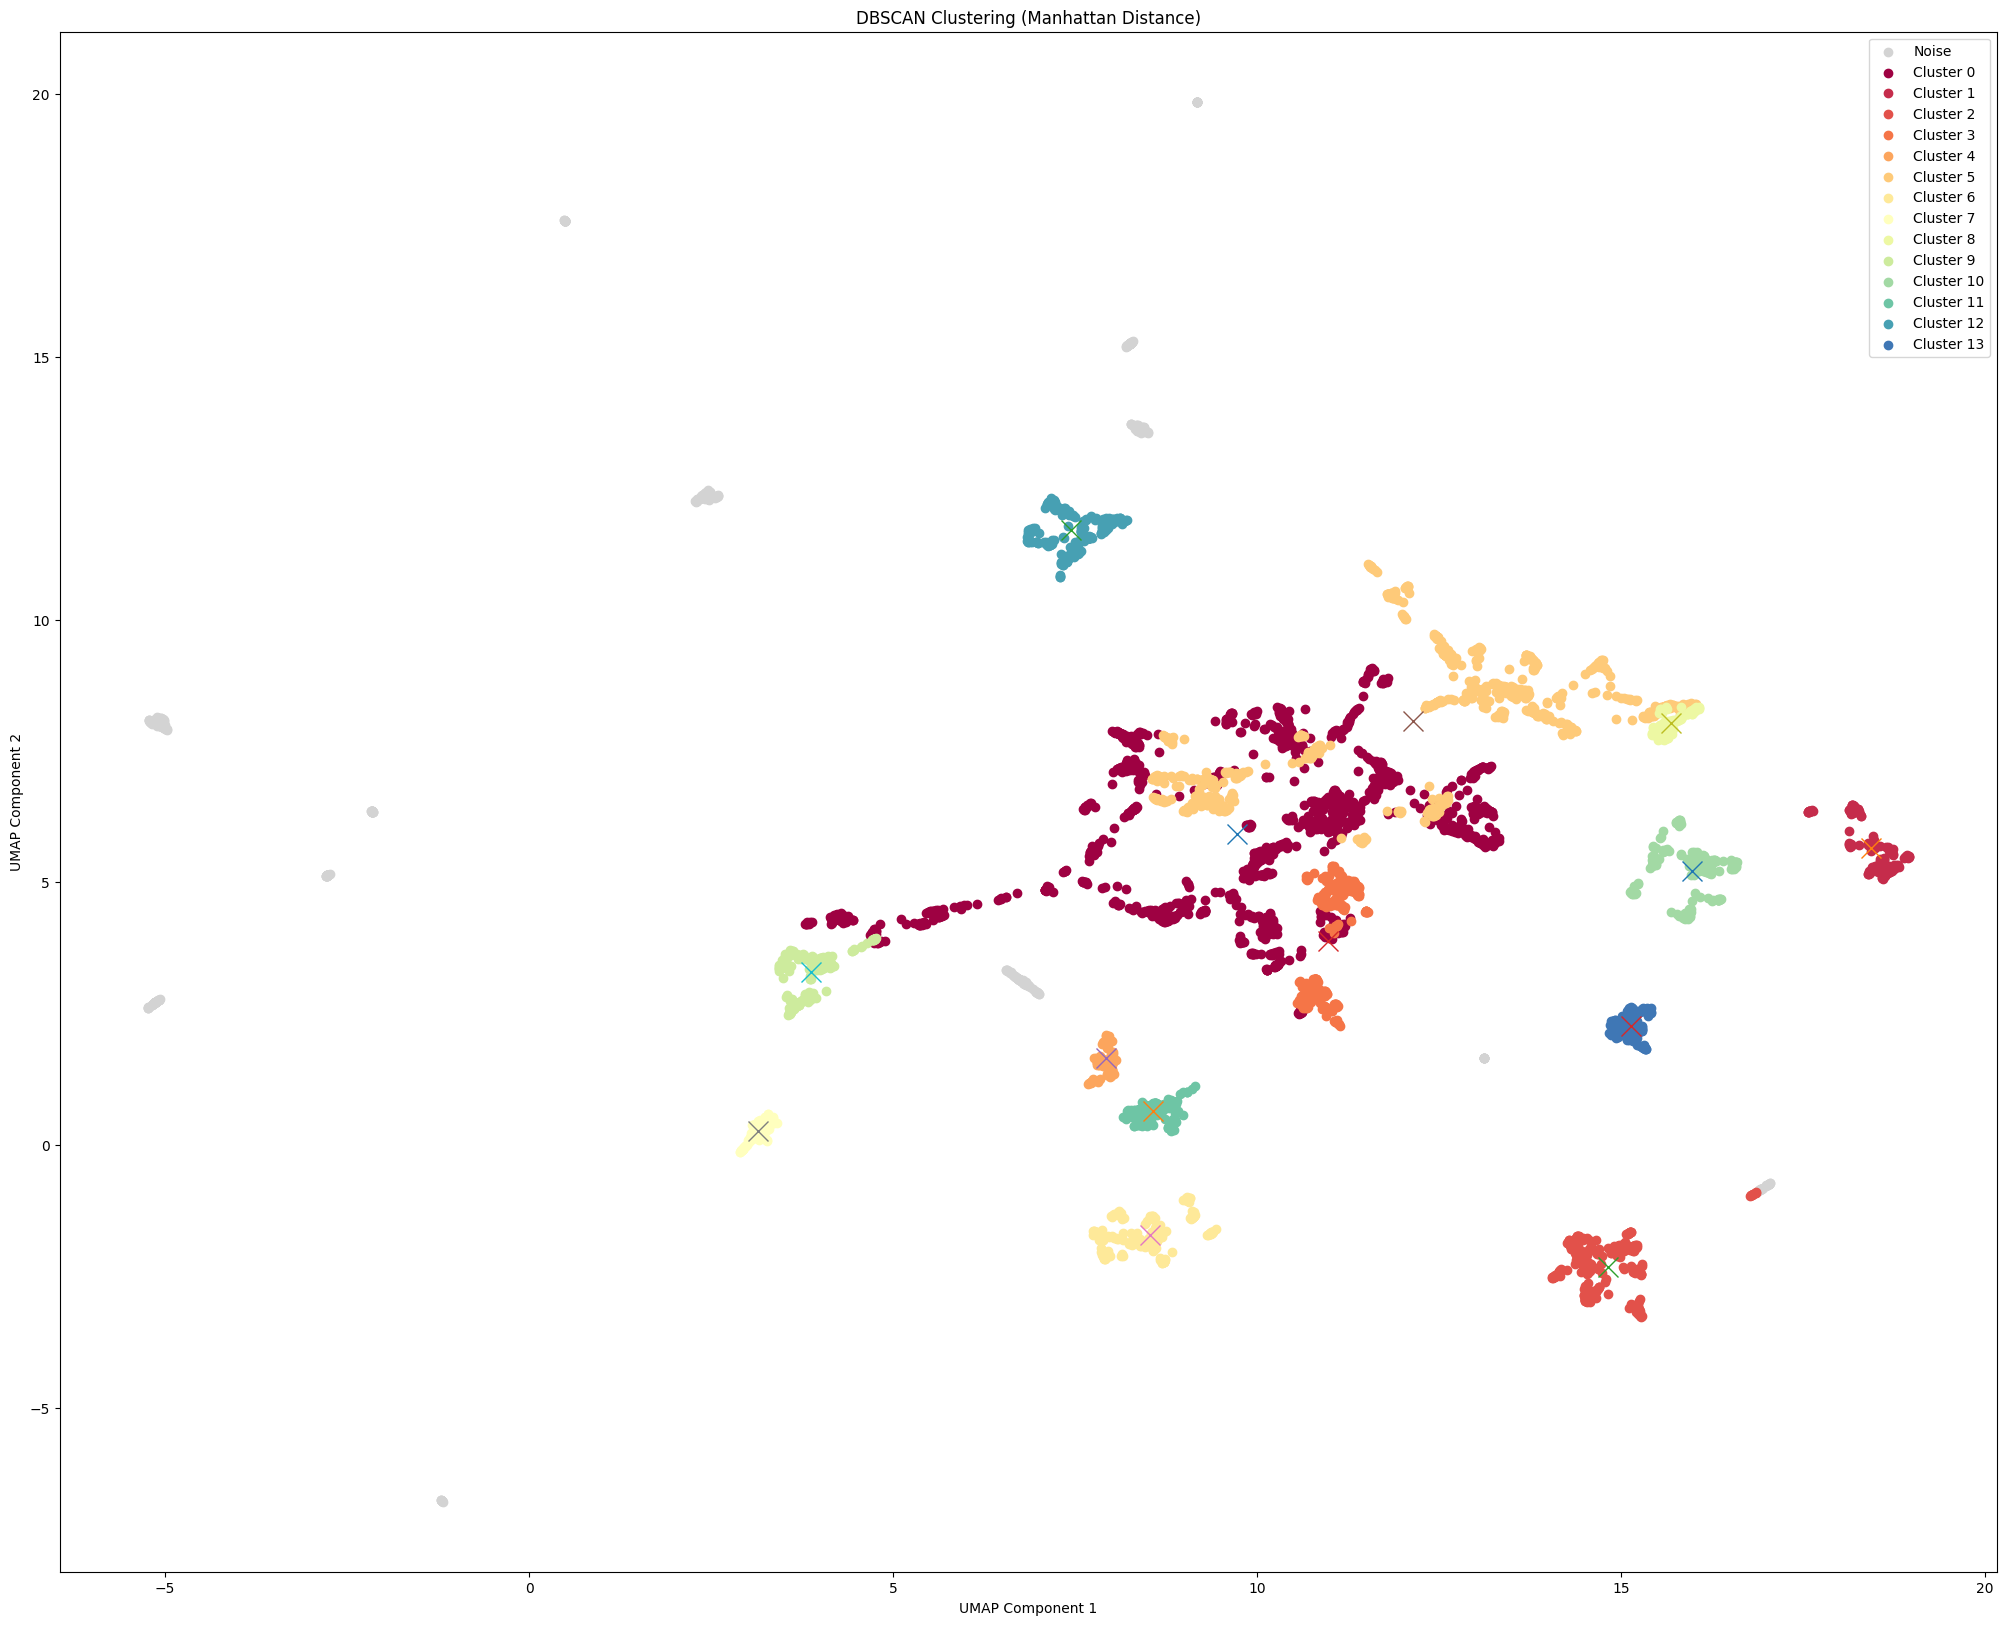

C:\Users\daanv\AppData\Local\Temp\ipykernel_33300\2837764344.py:71: RuntimeWarning: invalid value encountered in scalar divide
  color = plt.cm.Spectral(k / (len(set(labels)) - 1))


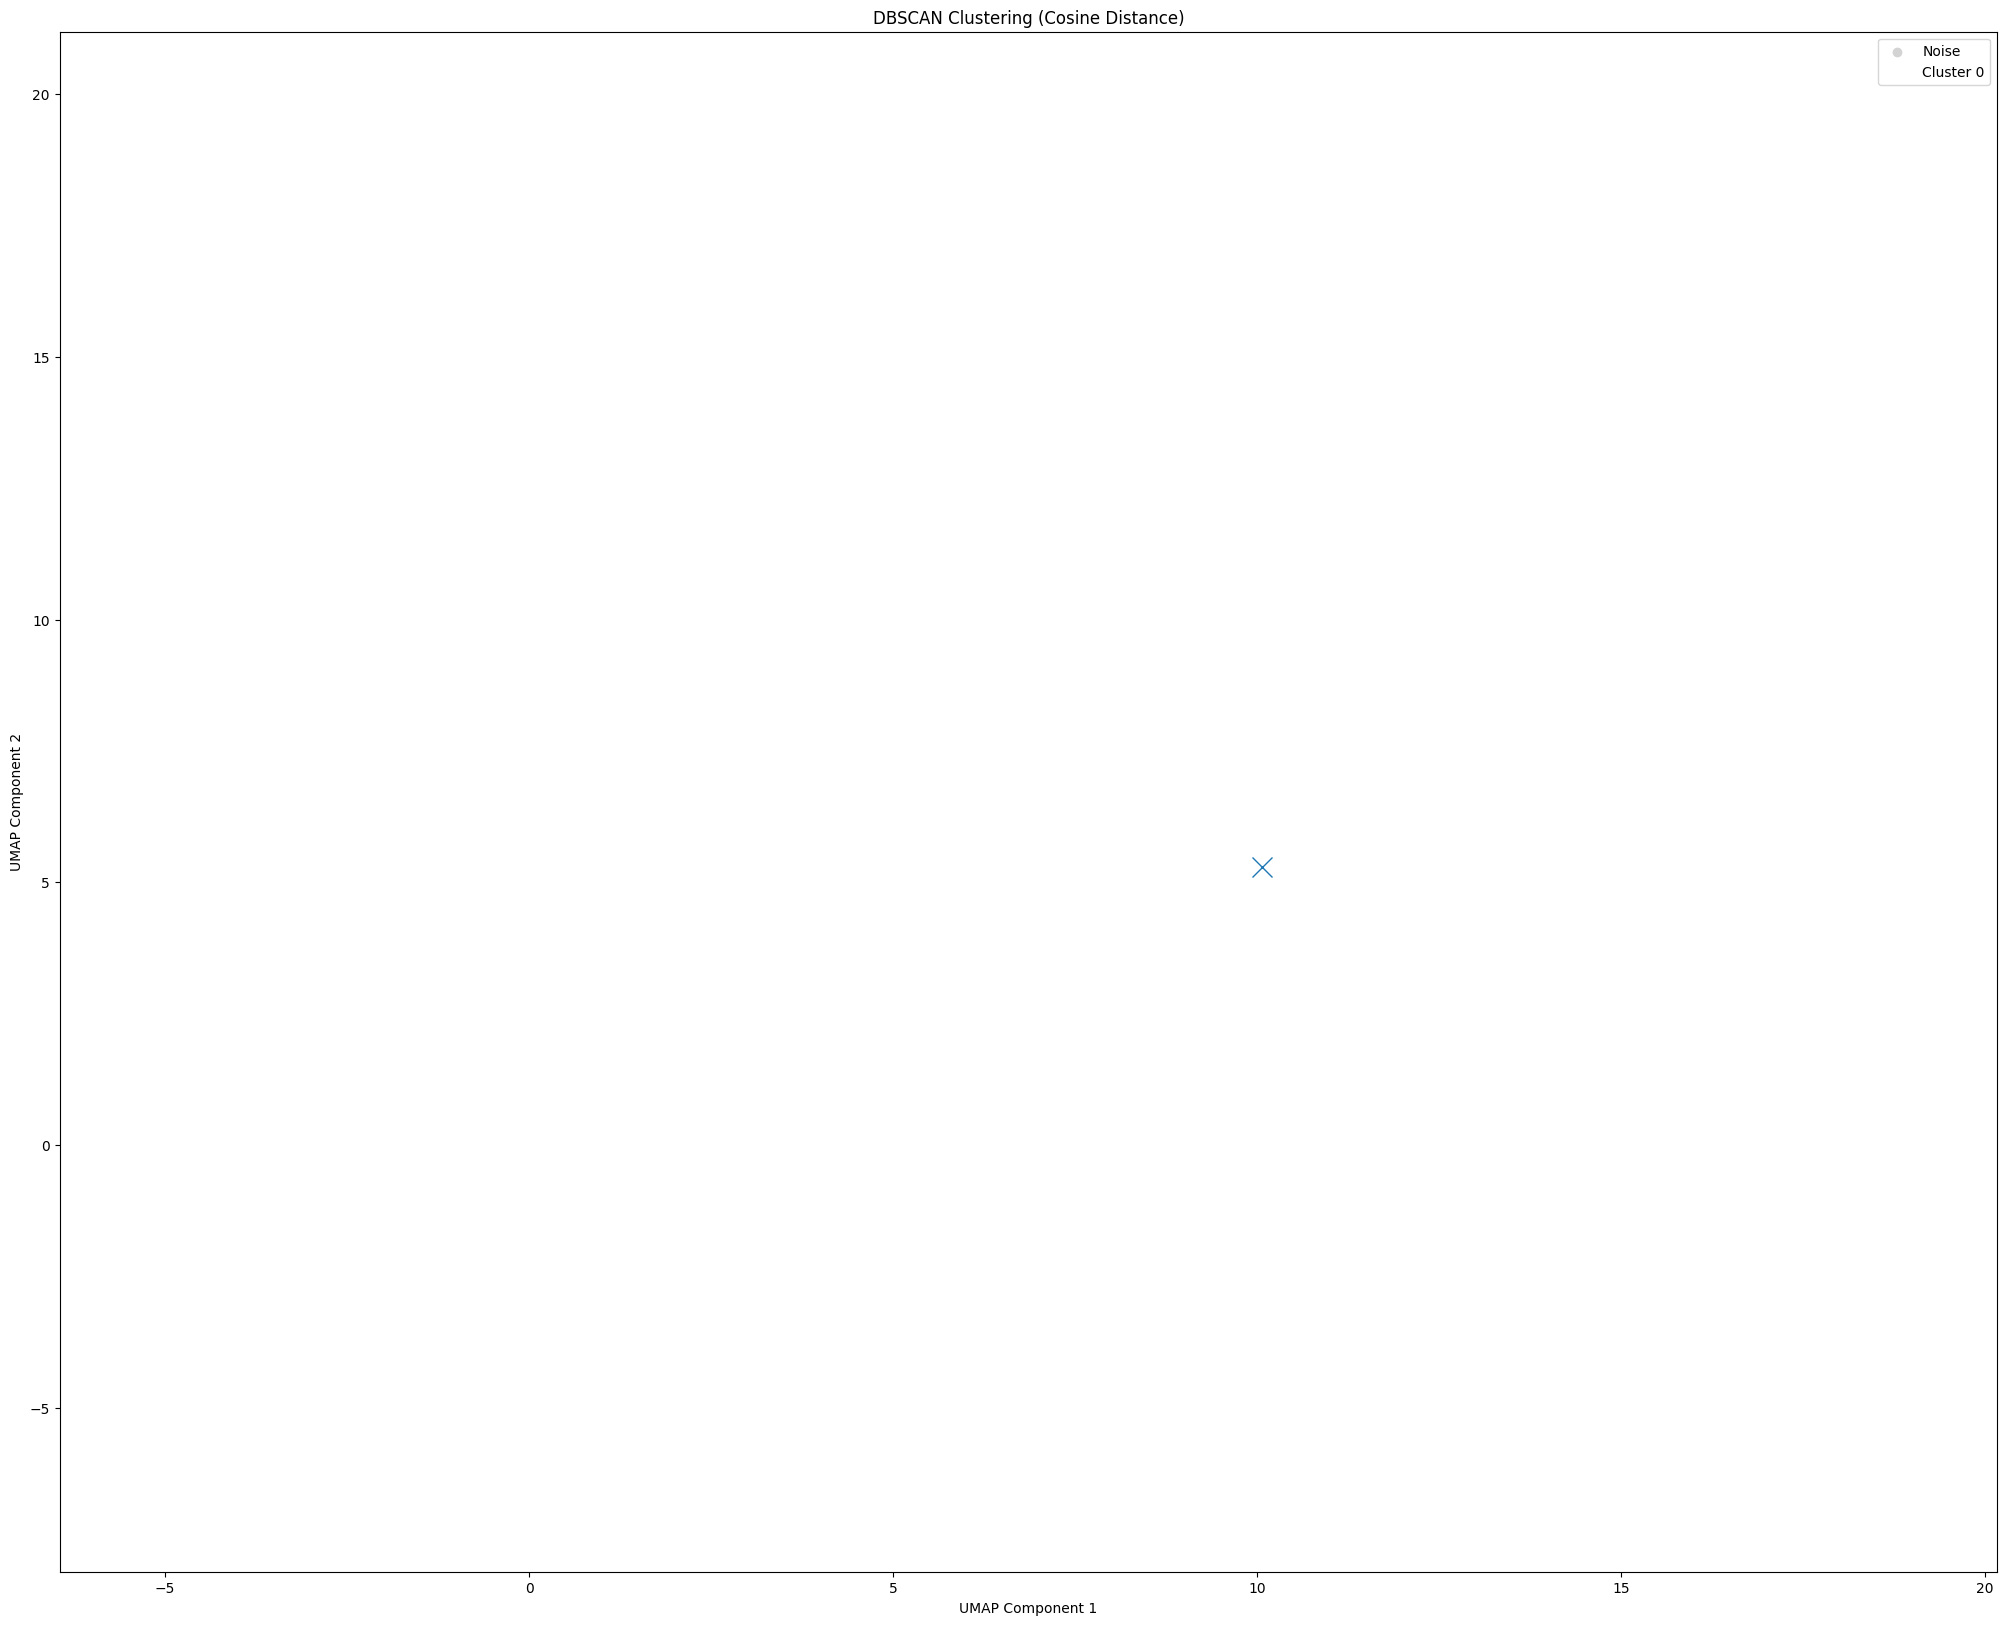

"\n# 5.4\ndf_cp_euclidean_DB = df.copy()\ndf_cp_euclidean_DB.dropna(inplace=True)\n\ndf_cp_euclidean_DB = one_hot_encode(df_cp)\n\nfor var in variables:\n    df_cp_euclidean_DB[var] = lin_norm(df_cp_euclidean_DB, var)\n\n\n\ndbscan = DBSCAN(eps=0.5, min_samples=5, metric = euclidean_distance)\ndf_cp_euclidean_DB['cluster'] = dbscan.fit_predict(df_cp_euclidean_DB)\n\nfig = px.scatter(df_cp_euclidean_DB, x=df_cp_euclidean_DB.columns[0], y=df_cp_euclidean_DB.columns[5], color='cluster', title='DBSCAN Clustering with Euclidean Distance')\nfig.show()\n"

In [22]:
# 5.1 

def euclidean_distance(x, y):
    sum = 0
    for i in range(len(x)):
        sum += (x[i] - y[i]) ** 2
    return math.sqrt(sum)


# 5.2
def manhatten_distance(x, y):
    sum = 0
    for i in range(len(x)):
        sum += abs(x[i] - y[i])
    return sum


# 5.3
def cosine_similarity(x, y):
    top = 0
    x_summed = 0
    y_summed = 0
    for i in range(len(x)):
        top += x[i] * y[i]
        x_summed += x[i] ** 2
        y_summed += y[i] ** 2
    return top / (math.sqrt(x_summed) * math.sqrt(y_summed))

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
import numpy as np

# Define function to run DBSCAN and plot
def run_dbscan(distance_metric, data, eps, min_samples):
    if distance_metric == 'cosine':
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        distance_matrix = pairwise_distances(data, metric='cosine')
        dbscan_labels = dbscan.fit_predict(distance_matrix)
    else:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=distance_metric)
        dbscan_labels = dbscan.fit_predict(data)
    
    return dbscan_labels

# Parameters
eps = 3
min_samples = 100

# Euclidean
dbscan_euclidean = DBSCAN(eps=eps, min_samples=min_samples, metric= euclidean_distance)
dbscan_euclidean_labels = dbscan_euclidean.fit_predict(df_inc_ump)

# Manhattan
dbscan_manhatten = DBSCAN(eps=eps, min_samples=min_samples, metric=manhatten_distance)
dbscan_manhatten_labels = dbscan_manhatten.fit_predict(df_inc_ump)

# Cosine
dbscan_cosine = DBSCAN(eps=eps, min_samples=min_samples, metric=cosine_similarity)
dbscan_cosine_labels = dbscan_cosine.fit_predict(df_inc_ump)

# Function to plot clusters
def plot_clusters(labels, title):
    plt.figure(figsize=(25, 20))
    noise_color = 'lightgray'
    plt.scatter(df_inc_ump[labels == -1, 0], df_inc_ump[labels == -1, 1], color=noise_color, label='Noise')

    for k in set(labels):
        if k != -1:
            color = plt.cm.Spectral(k / (len(set(labels)) - 1))
            plt.scatter(df_inc_ump[labels == k, 0], df_inc_ump[labels == k, 1], color=color, label=f'Cluster {k}')
    
    cluster_centers = []
    for k in set(labels):
        if k != -1:
            cluster_center = df_inc_ump[labels == k].mean(axis=0)
            cluster_centers.append(cluster_center)
            plt.plot(cluster_center[0], cluster_center[1], 'x', markersize=15)

    plt.title(title)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend()
    plt.show()

# Plot each clustering result
plot_clusters(dbscan_euclidean_labels, 'DBSCAN Clustering (Euclidean Distance)')
plot_clusters(dbscan_manhatten_labels, 'DBSCAN Clustering (Manhattan Distance)')
plot_clusters(dbscan_cosine_labels, 'DBSCAN Clustering (Cosine Distance)')

# Evaluation
def evaluate_clustering(labels, data):
    if len(set(labels)) > 1:
        silhouette = silhouette_score(data, labels)
        davies_bouldin = davies_bouldin_score(data, labels)
        calinski_harabasz = calinski_harabasz_score(data, labels)
    else:
        silhouette = davies_bouldin = calinski_harabasz = -1  # Handle noise-only case
    
    return silhouette, davies_bouldin, calinski_harabasz

results = {
    'Euclidean': evaluate_clustering(dbscan_euclidean_labels, df_inc_ump),
    'Manhattan': evaluate_clustering(dbscan_manhatten_labels, df_inc_ump),
    'Cosine': evaluate_clustering(dbscan_cosine_labels, df_inc_ump),
}

results